# Full Transfer Functions

In [1]:
%load_ext autoreload
import sys
sys.path.append("..")

In [81]:
%autoreload

import matplotlib
matplotlib.rc_file('matplotlibrc')
import matplotlib.pyplot as plt

%matplotlib inline

matplotlib.rcParams['figure.figsize'] = [10,10]


from astropy.io import fits

import numpy as np
import copy
import pickle

import darkhistory.physics as phys
import darkhistory.utilities as utils
import darkhistory.spec.spectools as spectools
import darkhistory.spec.transferfunction as tf
import darkhistory.spec.transferfunclist as tflist
from darkhistory.spec.spectrum import Spectrum
from darkhistory.spec.spectra import Spectra
import darkhistory.history.tla as tla

from scipy.interpolate import interp1d

from tqdm import tqdm_notebook as tqdm

from darkhistory.electrons.ics.ics_spectrum import ics_spec
from darkhistory.electrons.ics.ics_engloss_spectrum import engloss_spec
from darkhistory.electrons.ics.ics_cooling import get_ics_cooling_tf

from darkhistory.low_energy.lowE_deposition import compute_fs

# np.set_printoptions(threshold=np.nan)

In [3]:
# mDM = 1e11
# sigmav = 1e-24

# def rate_func_swave(rs):
#     return 0*phys.inj_rate('swave', rs, mDM=mDM, sigmav=sigmav)/(2*mDM)

# def test(rs, x1, x2, x3):
#     return 0.3

# test = tla.get_history(
#                 np.array([phys.TCMB(3000), 1, 0, 0]), 0.3, 0.3, 0.3, 
#                 rate_func_swave, np.flipud(np.arange(1, 3001)), reion_switch=False
#             )

# out = np.stack((np.flipud(np.arange(1, 3001)), test[:,0], test[:,1]))
# # pickle.dump(
# #     out, open("/Users/hongwan/GitHub/DarkHistory/darkhistory/history/std_soln.p", "wb")       
# #            )

In [4]:
soln = pickle.load(open("../darkhistory/history/std_soln.p", "rb"))
xe_std  = interp1d(soln[0,:], soln[2,:])
T_m_std = interp1d(soln[0,:], soln[1,:])

In [5]:
rs = 600
print(xe_std(rs))
print(T_m_std(rs)/phys.kB)
print(phys.TCMB(rs)/phys.kB)

0.0009648017275850074
1625.561215315584
1635.2995445551107


In [6]:
# plt.figure()

# plt.plot(np.flipud(np.arange(1, 3001)), test[:,0]/phys.kB)
# plt.plot(np.flipud(np.arange(1, 3001)), phys.TCMB(np.flipud(np.arange(1, 3001)))/phys.kB, 'k:')
# ax = plt.gca()

# ax.set_xscale('log')
# ax.set_yscale('log')

# plt.figure()

# plt.plot(np.flipud(np.arange(1, 3001)), test[:,1])
# ax = plt.gca()

# ax.set_xscale('log')
# ax.set_yscale('log')

## Photon Transfer Functions

In [7]:
user = 'hongwan'

highengphot_tflist_arr = pickle.load(open("/Users/"+user+"/Dropbox (MIT)/Photon Deposition/tfunclist_photspec_60eV_complete_coarse.raw", "rb"))
lowengphot_tflist_arr  = pickle.load(open("/Users/"+user+"/Dropbox (MIT)/Photon Deposition/tfunclist_lowengphotspec_60eV_complete_coarse.raw", "rb"))
lowengelec_tflist_arr  = pickle.load(open("/Users/"+user+"/Dropbox (MIT)/Photon Deposition/tfunclist_lowengelecspec_60eV_complete_coarse.raw", "rb"))
CMB_engloss_arr = pickle.load(open("/Users/"+user+"/Dropbox (MIT)/Photon Deposition/CMB_engloss_60eV_complete_coarse.raw", "rb"))

In [8]:
highengphot_tflist_arr[0]._grid_vals.shape

(51, 325, 500)

In [9]:
photeng = highengphot_tflist_arr[0].eng
eleceng = lowengelec_tflist_arr[0].eng

#Split photeng into high and low energy. 
photeng_high = photeng[photeng > 60]
photeng_low  = photeng[photeng <= 60]

# Split eleceng into high and low energy. 
eleceng_high = eleceng[eleceng > 3000]
eleceng_low  = eleceng[eleceng <= 3000]


for highengphot_tflist in highengphot_tflist_arr:
    
#     highengphot_tflist.at_val('in_eng', photeng_high, bounds_error=False, fill_value=0)

    for tf in highengphot_tflist:
        # tf.rebin(photeng_high)
#         tf.rebin(photeng)
        
        # Pad with zeros so that it becomes photeng x photeng. 
        tf._grid_vals = np.pad(tf.grid_vals, ((photeng_low.size, 0), (0, 0)), 'constant')
        tf._N_underflow = np.pad(tf._N_underflow, (photeng_low.size, 0), 'constant')
        tf._eng_underflow = np.pad(tf._eng_underflow, (photeng_low.size, 0), 'constant')
        tf._in_eng = photeng
        tf._eng = photeng
        tf._rs = tf.rs[0]*np.ones_like(photeng)
    
    highengphot_tflist._eng = photeng
    highengphot_tflist._in_eng = photeng
    highengphot_tflist._grid_vals = np.atleast_3d(
        np.stack([tf.grid_vals for tf in highengphot_tflist._tflist])
    )
    
# lowengphot_tflist.in_eng set to photeng_high
for lowengphot_tflist in lowengphot_tflist_arr:
    
#     lowengphot_tflist.at_val('in_eng', photeng_high, bounds_error=False, fill_value=0)
    
    for tf in lowengphot_tflist:
#         tf.rebin(photeng)
        # Pad with zeros so that it becomes photeng x photeng. 
        tf._grid_vals = np.pad(tf.grid_vals, ((photeng_low.size,0), (0,0)), 'constant')
        # Photons in the low energy bins should be immediately deposited.
        tf._grid_vals[0:photeng_low.size, 0:photeng_low.size] = np.identity(photeng_low.size)
        tf._N_underflow = np.pad(tf._N_underflow, (photeng_low.size, 0), 'constant')
        tf._eng_underflow = np.pad(tf._eng_underflow, (photeng_low.size, 0), 'constant')
        tf._in_eng = photeng
        tf._eng = photeng
        tf._rs = tf.rs[0]*np.ones_like(photeng)
    
    lowengphot_tflist._eng = photeng
    lowengphot_tflist._in_eng = photeng
    lowengphot_tflist._grid_vals = np.atleast_3d(
        np.stack([tf.grid_vals for tf in lowengphot_tflist._tflist])
    )
    
# lowengelec_tflist.in_eng set to photeng_high 
for lowengelec_tflist in lowengelec_tflist_arr:
    
#     lowengelec_tflist.at_val('in_eng', photeng_high, bounds_error=False, fill_value=0)
    
    for tf in lowengelec_tflist:
#         tf.rebin(eleceng)
        # Pad with zeros so that it becomes photeng x eleceng. 
        tf._grid_vals = np.pad(tf.grid_vals, ((photeng_low.size,0), (0,0)), 'constant')
        tf._N_underflow = np.pad(tf._N_underflow, (photeng_low.size, 0), 'constant')
        tf._eng_underflow = np.pad(tf._eng_underflow, (photeng_low.size, 0), 'constant')
        tf._in_eng = photeng
        tf._eng = eleceng
        tf._rs = tf.rs[0]*np.ones_like(photeng)

    lowengelec_tflist._eng = eleceng
    lowengelec_tflist._in_eng = photeng
    lowengelec_tflist._grid_vals = np.atleast_3d(
        np.stack([tf.grid_vals for tf in lowengelec_tflist._tflist])
    )
    
    for engloss in CMB_engloss_arr:
        engloss = np.pad(engloss, ((0,0),(photeng_low.size, 0)), 'constant')


In [10]:
xes = 0.5 + 0.5*np.tanh([-5., -4.1, -3.2, -2.3, -1.4, -0.5, 0.4, 1.3, 2.2, 3.1, 4])


In [11]:
highengphot_tf_interp = tflist.TransferFuncInterp(xes, highengphot_tflist_arr)
lowengphot_tf_interp = tflist.TransferFuncInterp(xes, lowengphot_tflist_arr)
lowengelec_tf_interp = tflist.TransferFuncInterp(xes, lowengelec_tflist_arr)


phot_spec_init = spectools.rebin_N_arr(np.array([2]), 
                                      np.array([1e11]), 
                                      photeng)
phot_spec_init.switch_spec_type()


In [87]:
phot_spec_init.rs = 1800
end_rs   = 18
mDM = 1e8
sigmav = 1e-26
tau = 1e26

def rate_func_swave_N(rs):
    # This is dN/dV dt
    return phys.inj_rate('swave', rs, mDM=mDM, sigmav=sigmav)/(2*mDM)

def rate_func_swave_eng(rs):
    # This is dN/dV dt
    return phys.inj_rate('swave', rs, mDM=mDM, sigmav=sigmav)

def rate_func_decay_N(rs):
    # This is dN/dV dt
    return phys.inj_rate('decay', rs, tau=tau)/mDM

def rate_func_decay_eng(rs):
    # This is dN/dV dt
    return phys.inj_rate('decay', rs, tau=tau)


def rate_func_swave_N_2(rs):
    # This is dN/dV dt
    return phys.inj_rate('swave', rs, mDM=mDM, sigmav=sigmav*1e-30)/(2*mDM)

def rate_func_swave_eng_2(rs):
    # This is dN/dV dt
    return phys.inj_rate('swave', rs, mDM=mDM, sigmav=sigmav*1e-30)


def evolve(
    in_spec_elec, in_spec_phot, 
    rate_func_N, rate_func_eng, xe_init, T_m_init,
    highengphot_tf_interp, lowengphot_tf_interp, 
    lowengelec_tf_interp, 
    end_rs, coarsen_factor=1, std_soln=False
):
    """
    Main function that computes the temperature and ionization history. 
    
    Parameters
    ----------
    in_spec_elec : Spectrum
        Spectrum per annihilation/decay into electrons. 
    in_spec_phot : Spectrum
        Spectrum per annihilation/decay into photons.
    rate_func_N : function
        Function describing the rate of annihilation/decay, dN/(dV dt)
    rate_func_eng : function
        Function describing the rate of annihilation/decay, dE/(dV dt)
    xe_init : float
        xe at the initial redshift. 
    T_m_init : float
        Matter temperature at the initial redshift. 
    highengphot_tf_interp : TransferFuncInterp
        Interpolation table for high energy photons. 
    lowengphot_tf_interp : TransferFuncInterp
        Interpolation table for low energy photons. 
    lowengelec_tf_interp : TransferFuncInterp
        Interpolation table for low energy electrons. 
    end_rs : float
        Final redshift to evolve to. 
    coarsen_factor : int
        Coarsening to apply to the transfer function matrix. 
    std_soln : bool
        If true, uses the standard TLA solution for f(z). 
    """
    
    # Initialize the next spectrum as None.
    next_highengphot_spec = None
    next_lowengphot_spec  = None
    next_lowengelec_spec  = None
    
    if (
        highengphot_tf_interp.dlnz    != lowengphot_tf_interp.dlnz
        or highengphot_tf_interp.dlnz != lowengelec_tf_interp.dlnz
        or lowengphot_tf_interp.dlnz  != lowengelec_tf_interp.dlnz
    ):
        raise TypeError('TransferFuncInterp objects must all have the same dlnz.')
    
    if in_spec_elec.rs != in_spec_phot.rs:
        raise TypeError('Input spectra must have the same rs.')
    
    # redshift/timestep related quantities. 
    dlnz = highengphot_tf_interp.dlnz
    prev_rs = None
    rs = in_spec_phot.rs
    dt = dlnz/phys.hubble(rs)
    
    # The initial input dN/dE per annihilation to per baryon per dlnz, 
    # based on the specified rate. 
    # dN/(dN_B d lnz dE) = dN/dE * (dN_ann/(dV dt)) * dV/dN_B * dt/dlogz
    
    # ICS for in_spec_elec goes here.
    
    init_inj_spec = (
        in_spec_phot * rate_func_N(rs) * dlnz
        / phys.hubble(rs) / (phys.nB * rs**3)
    )
    
    
    # Initialize the Spectra object that will contain all the 
    # output spectra during the evolution.
    out_highengphot_specs = Spectra([init_inj_spec], spec_type=init_inj_spec.spec_type)
    out_lowengphot_specs  = Spectra([], spec_type=init_inj_spec.spec_type)
    out_lowengelec_specs  = Spectra([], spec_type=init_inj_spec.spec_type)
    
    # Initialize the xe and T array that will store the solutions.
    xe_arr  = np.array([xe_init])
    T_m_arr = np.array([T_m_init])
    
    # Load the standard TLA solution if necessary. 
#     if std_soln:
    if True:
        soln = pickle.load(open("../darkhistory/history/std_soln.p", "rb"))
        xe_std  = interp1d(soln[0,:], soln[2,:])
        T_m_std = interp1d(soln[0,:], soln[1,:])

    # Define these methods for speed.
    append_highengphot_spec = out_highengphot_specs.append
    append_lowengphot_spec  = out_lowengphot_specs.append
    append_lowengelec_spec  = out_lowengelec_specs.append
    
    # Loop while we are still at a redshift above end_rs.
    while rs > end_rs:
        
        # If prev_rs exists, calculate xe and T_m. 
        if prev_rs is not None:
#             print('here at least?')
            
            # f_continuum, f_lyman, f_ionH, f_ionHe, f_heat
            # f_raw takes in dE/(dV dt)
            if std_soln:
                f_raw = compute_fs(
                    next_lowengelec_spec, next_lowengphot_spec,
                    np.array([1-xe_std(rs), 0, 0]), rate_func_eng(rs), dt
                )
                
            else:
                f_raw = compute_fs(
                    next_lowengelec_spec, next_lowengphot_spec,
                    np.array([1-xe_arr[-1], 0, 0]), rate_func_eng(rs), dt
                )
                
            std_f = compute_fs(
                    next_lowengelec_spec, next_lowengphot_spec,
                    np.array([1-xe_std(rs), 0, 0]), rate_func_eng(rs), dt
                )
            
            backreaction_f = compute_fs(
                    next_lowengelec_spec, next_lowengphot_spec,
                    np.array([1-xe_arr[-1], 0, 0]), rate_func_eng(rs), dt
                )
            
            init_cond = np.array([T_m_arr[-1], xe_arr[-1], 0, 0])

            new_vals = tla.get_history(
                init_cond, f_raw[2], f_raw[1], f_raw[4], 
                rate_func_eng, np.array([prev_rs, rs])
            )

            T_m_arr = np.append(T_m_arr, new_vals[-1,0])
            xe_arr  = np.append(xe_arr,  new_vals[-1,1])
            
        print('T_m at '+str(rs)+': '+ str(T_m_arr[-1]))
        print('x_e at '+str(rs)+': '+ str(xe_arr[-1]))
        print('Standard x_e at '+str(rs)+': '+str(xe_std(rs)))
        if prev_rs is not None:
            print('Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat: ', backreaction_f)
            print('Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat: ', std_f)
            
        if std_soln:
            highengphot_tf = highengphot_tf_interp.get_tf(rs, xe_std(rs))
            lowengphot_tf  = lowengphot_tf_interp.get_tf(rs, xe_std(rs))
            lowengelec_tf  = lowengelec_tf_interp.get_tf(rs, xe_std(rs))
        else:
            highengphot_tf = highengphot_tf_interp.get_tf(rs, xe_arr[-1])
            lowengphot_tf  = lowengphot_tf_interp.get_tf(rs, xe_arr[-1])
            lowengelec_tf  = lowengelec_tf_interp.get_tf(rs, xe_arr[-1])
        
#         if coarsen_factor > 1:
#             prop_tf = np.zeros_like(highengphot_tf._grid_vals)
#             for i in np.arange(coarsen_factor):
#                 prop_tf += matrix_power(highengphot_tf._grid_vals, i)
#             lowengphot_tf._grid_vals = np.matmul(prop_tf, lowengphot_tf._grid_vals)
#             lowengelec_tf._grid_vals = np.matmul(prof_tf, lowengelec_tf._grid_vals)
#             highengphot_tf._grid_vals = matrix_power(
#                 highengphot_tf._grid_vals, coarsen_factor
#             )
            
        next_highengphot_spec = highengphot_tf.sum_specs(out_highengphot_specs[-1])
        next_lowengphot_spec  = lowengphot_tf.sum_specs(out_highengphot_specs[-1])
        next_lowengelec_spec  = lowengelec_tf.sum_specs(out_highengphot_specs[-1])
        
        # Re-define existing variables.
        prev_rs = rs
        rs = np.exp(np.log(rs) - 0.002)
        
        dt = dlnz/phys.hubble(rs)
        next_highengphot_spec.rs = rs
        next_lowengphot_spec.rs  = rs
        next_lowengelec_spec.rs  = rs
        
        # Add the next injection spectrum to next_highengphot_spec
        next_inj_spec = (
            in_spec_phot * rate_func_N(rs) 
            / phys.hubble(rs) / (phys.nB * rs**3)
        )
        # This keeps the redshift. 
        next_highengphot_spec.N += next_inj_spec.N
        
        append_highengphot_spec(next_highengphot_spec)
        append_lowengphot_spec(next_lowengphot_spec)
        append_lowengelec_spec(next_lowengelec_spec)
        
        
    return (
        xe_arr, T_m_arr, 
        out_highengphot_specs, out_lowengphot_specs, out_lowengelec_specs
    )
        
        
            
        
            
    


In [88]:
a = evolve(
        phot_spec_init*0, phot_spec_init, 
        rate_func_decay_N, rate_func_decay_eng, .9999, phys.TCMB(phot_spec_init.rs),
        highengphot_tf_interp, lowengphot_tf_interp, 
        lowengelec_tf_interp, 
        end_rs, coarsen_factor=1, std_soln=False
    )

b = evolve(
        phot_spec_init*0, phot_spec_init, 
        rate_func_decay_N, rate_func_decay_eng, .9999, phys.TCMB(phot_spec_init.rs),
        highengphot_tf_interp, lowengphot_tf_interp, 
        lowengelec_tf_interp, 
        end_rs, coarsen_factor=1, std_soln=True
    )

T_m at 1800: 0.42275759247
x_e at 1800: 0.9999
Standard x_e at 1800: 0.9996009039448279
T_m at 1796.4035976012003: 0.42191257807882443
x_e at 1796.4035976012003: 0.9998223089545477
Standard x_e at 1796.4035976012003: 0.9995790683101462
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.68029446e-06 2.72273790e-07 1.50811787e-06 5.94251685e-21
 4.82124314e-06]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.68029446e-06 2.72273790e-07 1.50811787e-06 1.22503643e-20
 4.82124314e-06]


../darkhistory/spec/spectrum.py:748: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)


T_m at 1792.814380819186: 0.4210695937765904
x_e at 1792.814380819186: 0.9997556048868761
Standard x_e at 1792.814380819186: 0.9995561118097385
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [8.44436691e-04 1.36828911e-04 7.58059174e-04 3.53873067e-18
 2.42559728e-03]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [8.44436691e-04 1.36828911e-04 7.58059174e-04 6.50768964e-18
 2.42559728e-03]
T_m at 1789.2323352970852: 0.42022829395549577
x_e at 1789.2323352970852: 0.999696922397793
Standard x_e at 1789.2323352970852: 0.999531961084445
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.21878495e-03 3.58461721e-04 2.01722739e-03 1.17821477e-17
 6.89925692e-03]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.21878495e-03 3.58461721e-04 2.01722739e-03 1.99239321e-17
 6.89925692e-03]
T_m at 1785.6574467067112: 0.41938867521075823
x_e at 1785.6574467067112: 0.9996440509286635
Standard x_e at 1785.6574467067112: 0.9995065649978474
Back Reaction f_cont, f_lyman, f

T_m at 1722.5171234514928: 0.4045591859742074
x_e at 1722.5171234514928: 0.9987753717903347
Standard x_e at 1722.5171234514928: 0.9987606398541891
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [4.80785722e-03 7.70604428e-04 4.67299583e-03 4.00707899e-16
 2.13993187e-02]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [4.80785722e-03 7.70604428e-04 4.67299583e-03 4.89352858e-16
 2.13993187e-02]
T_m at 1719.0755319432956: 0.4037508746892771
x_e at 1719.0755319432956: 0.9987117521792033
Standard x_e at 1719.0755319432956: 0.9986981712975871
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [4.81889452e-03 7.72318465e-04 4.68413586e-03 4.72429470e-16
 2.14705963e-02]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [4.81889452e-03 7.72318465e-04 4.68413586e-03 5.79311697e-16
 2.14705963e-02]
T_m at 1715.640816739518: 0.40294417841882
x_e at 1715.640816739518: 0.9986454343796655
Standard x_e at 1715.640816739518: 0.9986328315694547
Back Reaction f_cont, f_lyman, f_i

T_m at 1645.0761334882275: 0.38637096740546617
x_e at 1645.0761334882275: 0.9964024040214936
Standard x_e at 1645.0761334882275: 0.9963978228601799
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.04971358e-03 8.08230715e-04 4.91074540e-03 1.91630243e-13
 2.28174137e-02]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.04971358e-03 8.08230715e-04 4.91074540e-03 2.93154057e-13
 2.28174137e-02]
T_m at 1641.7892691811799: 0.3855989964333117
x_e at 1641.7892691811799: 0.9962433815686615
Standard x_e at 1641.7892691811799: 0.9962388971687991
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.05985465e-03 8.09806332e-04 4.92064791e-03 2.90423782e-13
 2.28758547e-02]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.05985465e-03 8.09806332e-04 4.92064791e-03 4.51223576e-13
 2.28758547e-02]
T_m at 1638.5089720333979: 0.3848285678741145
x_e at 1638.5089720333979: 0.9960784395089571
Standard x_e at 1638.5089720333979: 0.9960740449658214
Back Reaction f_cont, f_lyma

T_m at 1580.5717756570334: 0.37122112340954827
x_e at 1580.5717756570334: 0.9918893707555195
Standard x_e at 1580.5717756570334: 0.9918860800742159
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.24641775e-03 8.38710271e-04 5.10233326e-03 2.79401255e-08
 2.39523327e-02]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.24642043e-03 8.38716334e-04 5.10233612e-03 6.45674146e-08
 2.39522845e-02]
T_m at 1577.4137911428952: 0.3704794222182935
x_e at 1577.4137911428952: 0.9915761762061079
Standard x_e at 1577.4137911428952: 0.991572915832409
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.25589193e-03 8.40178072e-04 5.11152886e-03 6.41793468e-08
 2.40069736e-02]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.25589800e-03 8.40192236e-04 5.11153549e-03 1.52392426e-07
 2.40068585e-02]
T_m at 1574.2621162860248: 0.36973920297195795
x_e at 1574.2621162860248: 0.9912530415846548
Standard x_e at 1574.2621162860248: 0.9912498351288633
Back Reaction f_cont, f_lyma

T_m at 1515.562511703329: 0.3559527051480194
x_e at 1515.562511703329: 0.9828673557319909
Standard x_e at 1515.562511703329: 0.9828643535207914
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.46374641e-03 8.73931601e-04 5.31111668e-03 1.01440115e-06
 2.51823035e-02]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.46375580e-03 8.73956093e-04 5.31113126e-03 8.83920056e-07
 2.51823855e-02]
T_m at 1512.534415785206: 0.35524151100444706
x_e at 1512.534415785206: 0.982286481103459
Standard x_e at 1512.534415785206: 0.9822834780155751
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.47525970e-03 8.75718287e-04 5.32203849e-03 8.86877526e-07
 2.52472690e-02]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.47526955e-03 8.75743952e-04 5.32205393e-03 7.78948454e-07
 2.52473260e-02]
T_m at 1509.512370006763: 0.3545317378762192
x_e at 1509.512370006763: 0.9816892321436475
Standard x_e at 1509.512370006763: 0.9816862288646808
Back Reaction f_cont, f_lyman, f_ionH,

T_m at 1456.136455619734: 0.34199560803314066
x_e at 1456.136455619734: 0.9676337131254535
Standard x_e at 1456.136455619734: 0.9676308271334506
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.68234418e-03 9.07974918e-04 5.51720236e-03 2.02647404e-07
 2.64115606e-02]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.68237364e-03 9.08050578e-04 5.51727035e-03 1.92229793e-07
 2.64113979e-02]
T_m at 1453.2270930408613: 0.3413123015564672
x_e at 1453.2270930408613: 0.9666369262222603
Standard x_e at 1453.2270930408613: 0.9666339376421398
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.69255931e-03 9.09584929e-04 5.52675019e-03 1.92558785e-07
 2.64684511e-02]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.69259142e-03 9.09667293e-04 5.52682692e-03 1.82810386e-07
 2.64682697e-02]
T_m at 1450.3235433722982: 0.340630360423672
x_e at 1450.3235433722982: 0.9656134972986918
Standard x_e at 1450.3235433722982: 0.9656104249929285
Back Reaction f_cont, f_lyman, f

T_m at 1393.4555438260868: 0.32727410487012126
x_e at 1393.4555438260868: 0.9383613449598969
Standard x_e at 1393.4555438260868: 0.938357829628961
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.88939649e-03 9.48048391e-04 5.73185123e-03 1.15570779e-07
 2.74911435e-02]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.88953665e-03 9.48422040e-04 5.73267103e-03 1.18748657e-07
 2.74898067e-02]
T_m at 1390.6714177925103: 0.3266202151394968
x_e at 1390.6714177925103: 0.9365900664331268
Standard x_e at 1390.6714177925103: 0.9365866113656907
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.89758347e-03 9.49591136e-04 5.73983237e-03 1.18873328e-07
 2.75329390e-02]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.89773214e-03 9.49987449e-04 5.74070240e-03 1.22241651e-07
 2.75315207e-02]
T_m at 1387.8928544464595: 0.32596763209226376
x_e at 1387.8928544464595: 0.9347721853272357
Standard x_e at 1387.8928544464595: 0.9347691221996259
Back Reaction f_cont, f_lyma

T_m at 1338.8173704363674: 0.3144416388595368
x_e at 1338.8173704363674: 0.8925596133519047
Standard x_e at 1338.8173704363674: 0.8925560009214795
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.04460904e-03 9.83544140e-04 5.89139694e-03 2.28668457e-07
 2.82363596e-02]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.04492346e-03 9.84211409e-04 5.89174198e-03 2.30331050e-07
 2.82350313e-02]
T_m at 1336.1424115460381: 0.3138133943937331
x_e at 1336.1424115460381: 0.8895925958691742
Standard x_e at 1336.1424115460381: 0.8895891190408438
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.05322991e-03 9.85361433e-04 5.89885234e-03 2.30580996e-07
 2.82793552e-02]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.05356397e-03 9.86066223e-04 5.89921319e-03 2.32632318e-07
 2.82779534e-02]
T_m at 1333.4727972271367: 0.3131864055792154
x_e at 1333.4727972271367: 0.8865491377748241
Standard x_e at 1333.4727972271367: 0.8865448847509045
Back Reaction f_cont, f_lyman

T_m at 1281.1865809727458: 0.3009065116192976
x_e at 1281.1865809727458: 0.8067991651035699
Standard x_e at 1281.1865809727458: 0.8067950874905934
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.18818395e-03 1.02878690e-03 5.99794591e-03 1.52785570e-06
 2.87714367e-02]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.18972430e-03 1.03152799e-03 5.99901095e-03 2.91980912e-06
 2.87646983e-02]
T_m at 1278.6267684765676: 0.3003053230555637
x_e at 1278.6267684765676: 0.801727802924121
Standard x_e at 1278.6267684765676: 0.8017229178560155
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.19237971e-03 1.03163118e-03 5.99955552e-03 2.91859966e-06
 2.87688924e-02]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.19406754e-03 1.03461122e-03 6.00067824e-03 6.79333418e-06
 2.87592270e-02]
T_m at 1276.072070489168: 0.2997053364247883
x_e at 1276.072070489168: 0.7965410258846173
Standard x_e at 1276.072070489168: 0.7965377482296027
Back Reaction f_cont, f_lyman, f_

T_m at 1223.5869462246303: 0.28737906756928505
x_e at 1223.5869462246303: 0.6597850033776482
Standard x_e at 1223.5869462246303: 0.6597802951729382
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.19550232e-03 1.07671677e-03 5.98031947e-03 3.10868087e-05
 2.80516930e-02]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.19646620e-03 1.07975623e-03 5.98374237e-03 3.15522848e-05
 2.80438013e-02]
T_m at 1221.1422178754399: 0.28680492559245746
x_e at 1221.1422178754399: 0.6519814757836214
Standard x_e at 1221.1422178754399: 0.6519780439087577
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.19129836e-03 1.07818006e-03 5.97504827e-03 3.14801978e-05
 2.79938647e-02]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.19230493e-03 1.08137193e-03 5.97863430e-03 3.19641593e-05
 2.79855963e-02]
T_m at 1218.702374096749: 0.28623193145235604
x_e at 1218.702374096749: 0.6440740579842363
Standard x_e at 1218.702374096749: 0.6440698310052597
Back Reaction f_cont, f_lyman

T_m at 1170.9163705020255: 0.2750095250112152
x_e at 1170.9163705020255: 0.47117433375503404
Standard x_e at 1170.9163705020255: 0.4711727454874206
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.07147157e-03 1.14498360e-03 5.86032548e-03 4.40768948e-05
 2.63456411e-02]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.07482700e-03 1.15228607e-03 5.87009124e-03 4.43786463e-05
 2.63249157e-02]
T_m at 1168.5768780333212: 0.27446010086106826
x_e at 1168.5768780333212: 0.4622400020974499
Standard x_e at 1168.5768780333212: 0.4622385373179657
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.06770797e-03 1.14986736e-03 5.85825579e-03 4.42340103e-05
 2.62602030e-02]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.07123817e-03 1.15751157e-03 5.86852942e-03 4.45429352e-05
 2.62384461e-02]
T_m at 1166.2420598736871: 0.27391177382180015
x_e at 1166.2420598736871: 0.4533264344045894
Standard x_e at 1166.2420598736871: 0.45332508964155865
Back Reaction f_cont, f_l

T_m at 1120.513054621895: 0.26317216736624577
x_e at 1120.513054621895: 0.28866970996623126
Standard x_e at 1120.513054621895: 0.2886714744931576
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.04196983e-03 1.35075599e-03 5.97256914e-03 4.89581360e-05
 2.41585114e-02]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.04622186e-03 1.36252969e-03 5.99072820e-03 4.94028646e-05
 2.41238819e-02]
T_m at 1118.2742680454899: 0.2626463634099455
x_e at 1118.2742680454899: 0.2814828672264722
Standard x_e at 1118.2742680454899: 0.28148416370868284
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.04003308e-03 1.35973375e-03 5.97943326e-03 4.92555886e-05
 2.40688633e-02]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.04439330e-03 1.37185389e-03 5.99832231e-03 4.97076876e-05
 2.40330418e-02]
T_m at 1116.0399545676482: 0.2621216079032839
x_e at 1116.0399545676482: 0.2744191635760458
Standard x_e at 1116.0399545676482: 0.2744187478684692
Back Reaction f_cont, f_lyman

T_m at 1076.5771093130318: 0.2528528737227216
x_e at 1076.5771093130318: 0.16900373405926822
Standard x_e at 1076.5771093130318: 0.16900616223084677
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.11475677e-03 1.64509818e-03 6.25951842e-03 6.07071089e-05
 2.24016725e-02]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.12838371e-03 1.67246185e-03 6.28287183e-03 6.21524951e-05
 2.23358831e-02]
T_m at 1074.4261068139058: 0.25234763680031375
x_e at 1074.4261068139058: 0.1643266011324126
Standard x_e at 1074.4261068139058: 0.16432902902906193
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.12784913e-03 1.67080702e-03 6.27747499e-03 6.20608785e-05
 2.23132452e-02]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.14203585e-03 1.69909780e-03 6.30129911e-03 6.35376612e-05
 2.22454668e-02]
T_m at 1072.2794020206397: 0.25184340627377705
x_e at 1072.2794020206397: 0.1597654386873345
Standard x_e at 1072.2794020206397: 0.15976736461775998
Back Reaction f_cont, f

T_m at 1034.3639170611016: 0.24293699536661115
x_e at 1034.3639170611016: 0.09530019659966604
Standard x_e at 1034.3639170611016: 0.09530202175744189
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.35137708e-03 2.07519224e-03 6.83106937e-03 8.65488579e-05
 2.09527849e-02]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.36339160e-03 2.10480562e-03 6.86535786e-03 8.85073776e-05
 2.08749100e-02]
T_m at 1032.2972565763512: 0.24245149408121405
x_e at 1032.2972565763512: 0.09257090352967207
Standard x_e at 1032.2972565763512: 0.0925725085142552
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.37099215e-03 2.10638039e-03 6.87016695e-03 8.85825450e-05
 2.08902055e-02]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.38324560e-03 2.13663964e-03 6.90506319e-03 9.05860561e-05
 2.08107931e-02]
T_m at 1030.2347252820034: 0.24196695792978135
x_e at 1030.2347252820034: 0.08991798797396189
Standard x_e at 1030.2347252820034: 0.08991932555314774
Back Reaction f_cont,

T_m at 987.8609449693131: 0.2320109783276943
x_e at 987.8609449693131: 0.0487576835591908
Standard x_e at 987.8609449693131: 0.04875821749519472
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.00691201 0.00300135 0.0079587  0.00014835 0.01927863]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.0069271  0.00303667 0.00800195 0.00015122 0.01918209]
T_m at 985.887197484775: 0.2315471493539502
x_e at 985.887197484775: 0.04736006622684669
Standard x_e at 985.887197484775: 0.047360491074851484
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.00693886 0.00304133 0.00801306 0.00015149 0.01921015]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.0069537  0.00307538 0.00805605 0.00015436 0.0191154 ]
T_m at 983.9173935503414: 0.23108423974813225
x_e at 983.9173935503414: 0.04600325215043438
Standard x_e at 983.9173935503414: 0.04600355020890234
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.00696557 0.00308017 0.00806739 0.00015464 0.01914375]
Stan

T_m at 939.6823981698964: 0.22068554131213397
x_e at 939.6823981698964: 0.02375613285773931
Standard x_e at 939.6823981698964: 0.023756651226864364
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.0076523  0.00412518 0.00949553 0.00020229 0.01740436]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.00767091 0.00417043 0.00954692 0.00020058 0.01729082]
T_m at 937.8049114860695: 0.22024400238374928
x_e at 937.8049114860695: 0.023094558546591926
Standard x_e at 937.8049114860695: 0.023094906543928113
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.00768502 0.0041783  0.00956335 0.00020102 0.01732128]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.00770377 0.00422391 0.00961502 0.00019936 0.01720692]
T_m at 935.931176023139: 0.2198033233067437
x_e at 935.931176023139: 0.02245265598266094
Standard x_e at 935.931176023139: 0.02245275757796946
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.00771794 0.0042319  0.00963163 0.0001998  0.01723735]


T_m at 892.0676262468419: 0.20948029503230942
x_e at 892.0676262468419: 0.011674311648459501
Standard x_e at 892.0676262468419: 0.011674316127376006
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.0085898  0.00547792 0.01117247 0.00027178 0.01552595]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.0086058  0.00550332 0.01121758 0.00027268 0.01543854]
T_m at 890.2852739407718: 0.2090604796273964
x_e at 890.2852739407718: 0.011374163150433492
Standard x_e at 890.2852739407718: 0.011374351728020156
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.00862717 0.00551832 0.01124571 0.00027356 0.015478  ]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.00864318 0.00554365 0.01129089 0.00027446 0.01539058]
T_m at 888.5064827769846: 0.20864147313239584
x_e at 888.5064827769846: 0.011083050702167974
Standard x_e at 888.5064827769846: 0.011083290324151403
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.00866461 0.00555875 0.01131919 0.00027534 0.0154

T_m at 848.560974730506: 0.19922211482236704
x_e at 848.560974730506: 0.006346042892077131
Standard x_e at 848.560974730506: 0.006346102798470219
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.00950141 0.00666956 0.01293877 0.00029875 0.01425977]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.00951507 0.00670271 0.01297648 0.00029857 0.01417542]
T_m at 846.8655487721455: 0.19882185430701788
x_e at 846.8655487721455: 0.00620591043767682
Standard x_e at 846.8655487721455: 0.006205876702270282
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.00953718 0.00671975 0.01300734 0.00029946 0.0142094 ]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.00955079 0.00675276 0.01304485 0.00029928 0.01412545]
T_m at 845.1735102771092: 0.1984223597356894
x_e at 845.1735102771092: 0.006069936477672011
Standard x_e at 845.1735102771092: 0.006069917865547725
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.0095729  0.00676985 0.01307577 0.00030017 0.01415925

T_m at 810.4113383450921: 0.19020531764115736
x_e at 810.4113383450921: 0.003975843647029076
Standard x_e at 810.4113383450921: 0.003975791922813417
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01027526 0.00770814 0.01444002 0.00030644 0.01332926]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01028424 0.00772926 0.0144694  0.00030561 0.01327059]
T_m at 808.7921354110704: 0.18982211962557133
x_e at 808.7921354110704: 0.0039044801144157426
Standard x_e at 808.7921354110704: 0.0039043971986131524
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.0103064  0.00774737 0.01450149 0.00030646 0.01330012]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01031531 0.0077683  0.01453063 0.00030565 0.01324194]
T_m at 807.1761676466687: 0.1894396504802426
x_e at 807.1761676466687: 0.0038351016155399043
Standard x_e at 807.1761676466687: 0.0038350097593585226
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01033745 0.00778643 0.01456274 0.00030649 0.

T_m at 772.4304280074107: 0.1812064819621687
x_e at 772.4304280074107: 0.002702399842502423
Standard x_e at 772.4304280074107: 0.002702275514416464
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01113451 0.0087112  0.01582863 0.00034009 0.01284441]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01114841 0.00873544 0.0158302  0.00034334 0.01280145]
T_m at 770.8871109828596: 0.18084037306469486
x_e at 770.8871109828596: 0.0026647818465148077
Standard x_e at 770.8871109828596: 0.002664628726479116
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01117693 0.00875859 0.01587042 0.00034438 0.01283402]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01119076 0.00878266 0.0158719  0.00034763 0.0127914 ]
T_m at 769.3468775077803: 0.18047496147260597
x_e at 769.3468775077803: 0.0026280872252143483
Standard x_e at 769.3468775077803: 0.0026279541579624136
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01121927 0.00880583 0.01591206 0.00034868 0.0

Standard x_e at 736.2295391006052: 0.002005887852424972
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01212751 0.00980583 0.0167933  0.00044586 0.01265189]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01213941 0.00982588 0.01679316 0.00044915 0.0126168 ]
T_m at 734.7585515003335: 0.1722602419166713
x_e at 734.7585515003335: 0.001984448537604544
Standard x_e at 734.7585515003335: 0.001984249507299194
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01216773 0.00984954 0.0168319  0.00045036 0.01264624]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01217465 0.00986546 0.01684505 0.0004496  0.01261099]
T_m at 733.2905029352476: 0.17191121034635984
x_e at 733.2905029352476: 0.00196326410016201
Standard x_e at 733.2905029352476: 0.001963064614869544
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01220301 0.00988917 0.0168836  0.00045086 0.01264032]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.012208   0.00990344 0.01690172 0.

T_m at 700.3232007790984: 0.16406515623876053
x_e at 700.3232007790984: 0.0015762788193741661
Standard x_e at 700.3232007790984: 0.0015760130528955992
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01294959 0.01073054 0.01814538 0.0004319  0.01254724]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01295358 0.01074226 0.01816051 0.00043017 0.01251812]
T_m at 698.9239540906443: 0.16373179653157308
x_e at 698.9239540906443: 0.0015629473890845236
Standard x_e at 698.9239540906443: 0.0015626705921603385
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01298116 0.01076571 0.0181984  0.00043127 0.01254497]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01298512 0.01077735 0.01821343 0.00042956 0.01251605]
T_m at 697.5275030989385: 0.16339907403789417
x_e at 697.5275030989385: 0.0015498486279413304
Standard x_e at 697.5275030989385: 0.001549578071290936
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01301371 0.010802   0.01825314 0.00043071 

T_m at 666.1680352416034: 0.1559194070247215
x_e at 666.1680352416034: 0.0013016102369969307
Standard x_e at 666.1680352416034: 0.0013012547889593015
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01391152 0.01170281 0.01956814 0.00044837 0.01288623]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01391431 0.01171012 0.01957373 0.0004481  0.01287081]
T_m at 664.8370306194107: 0.15560159684606314
x_e at 664.8370306194107: 0.001292719649183649
Standard x_e at 664.8370306194107: 0.00129236026512043
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01394996 0.01174069 0.01962273 0.00044943 0.01290371]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01395273 0.01174797 0.01962829 0.00044917 0.01288836]
T_m at 663.508685346227: 0.1552843922004294
x_e at 663.508685346227: 0.0012839597473321418
Standard x_e at 663.508685346227: 0.0012836001094079042
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01398834 0.01177851 0.01967722 0.00045049 0.01292

T_m at 631.1489849131203: 0.14754742496643408
x_e at 631.1489849131203: 0.0011004824569588179
Standard x_e at 631.1489849131203: 0.0011000114309727717
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01492912 0.01270261 0.02100916 0.00047695 0.01335557]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01493163 0.01270921 0.02101411 0.00047675 0.01334172]
T_m at 629.8879484001526: 0.14724552760315832
x_e at 629.8879484001526: 0.0010943315745041704
Standard x_e at 629.8879484001526: 0.0010938552145105264
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01496602 0.01273875 0.02106125 0.000478   0.0133728 ]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01496852 0.01274532 0.02106618 0.0004778  0.01335899]
T_m at 628.6294314398184: 0.14694420240683156
x_e at 628.6294314398184: 0.0010882571351947257
Standard x_e at 628.6294314398184: 0.0010877786417225865
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01500285 0.01277481 0.02111325 0.00047905

T_m at 602.7737649861073: 0.14074641986864406
x_e at 602.7737649861073: 0.0009761539256368246
Standard x_e at 602.7737649861073: 0.0009755639461422328
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01583509 0.01357962 0.0222814  0.00050445 0.01379727]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01583794 0.01358643 0.02228698 0.0005046  0.01378188]
T_m at 601.5694222003684: 0.14045738004005942
x_e at 601.5694222003684: 0.000971460520544809
Standard x_e at 601.5694222003684: 0.00097086582421351
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01588215 0.01362404 0.02234666 0.00050614 0.01382083]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01588499 0.01363084 0.02235223 0.00050628 0.01380546]
T_m at 600.3674856931206: 0.1401688850938617
x_e at 600.3674856931206: 0.0009668184874110919
Standard x_e at 600.3674856931206: 0.000966217815159737
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01592918 0.01366846 0.0224119  0.00050783 0.01

T_m at 574.5240413721772: 0.13395752736820096
x_e at 574.5240413721772: 0.0008761863758272592
Standard x_e at 574.5240413721772: 0.0008754461664253505
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01695054 0.01463301 0.02382653 0.00054475 0.01435558]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01695332 0.01463966 0.02383196 0.0005449  0.01434058]
T_m at 573.3761415718666: 0.13368124910184387
x_e at 573.3761415718666: 0.000872528883151924
Standard x_e at 573.3761415718666: 0.0008717815906596312
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01699628 0.01467614 0.02388972 0.00054641 0.01437837]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01699906 0.01468279 0.02389514 0.00054656 0.01436337]
T_m at 572.2305352768867: 0.13340548850223063
x_e at 572.2305352768867: 0.0008689069610008371
Standard x_e at 572.2305352768867: 0.0008681520845544808
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01704195 0.01471921 0.0239528  0.00054807 

T_m at 546.5041732362836: 0.12720335782114914
x_e at 546.5041732362836: 0.0007943609655193806
Standard x_e at 546.5041732362836: 0.0007934313916201838
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01807556 0.01569229 0.02537657 0.00058575 0.01491283]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01807836 0.015699   0.02538201 0.00058591 0.01489772]
T_m at 545.4122571698496: 0.12693969495211452
x_e at 545.4122571698496: 0.0007914597073002683
Standard x_e at 545.4122571698496: 0.0007905217800329403
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01811977 0.01573385 0.0254373  0.00058736 0.01493458]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01812257 0.01574056 0.02544275 0.00058753 0.01491945]
T_m at 544.3225227531715: 0.12667652281041564
x_e at 544.3225227531715: 0.0007885837407253793
Standard x_e at 544.3225227531715: 0.0007876372741692668
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01816391 0.01577534 0.02549793 0.00058898

T_m at 519.8508501947914: 0.12075662758918927
x_e at 519.8508501947914: 0.0007287381007360927
Standard x_e at 519.8508501947914: 0.0007275817652319021
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01935541 0.01687249 0.0271119  0.00063228 0.01558579]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01935835 0.01687955 0.02711761 0.00063246 0.01556989]
T_m at 518.8121875033142: 0.12050492437039716
x_e at 518.8121875033142: 0.0007263835799617979
Standard x_e at 518.8121875033142: 0.0007252174798521514
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01941184 0.01692383 0.02718757 0.00063432 0.01561637]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01941479 0.01693091 0.02719329 0.00063451 0.01560042]
T_m at 517.775600061279: 0.12025368640295944
x_e at 517.775600061279: 0.000724047690746854
Standard x_e at 517.775600061279: 0.0007228717234894675
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01946821 0.0169751  0.02726313 0.00063637 0.0

T_m at 492.5233860668049: 0.11412108782692129
x_e at 492.5233860668049: 0.0006711301887423193
Standard x_e at 492.5233860668049: 0.0006696797279206613
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.02085578 0.01823483 0.02911632 0.00068682 0.01638926]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.02085902 0.01824262 0.0291226  0.00068704 0.01637173]
T_m at 491.5393236850739: 0.11388160553063284
x_e at 491.5393236850739: 0.0006692119297061483
Standard x_e at 491.5393236850739: 0.0006677494438190085
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.0209104  0.01828431 0.029189   0.00068881 0.01641814]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.02091365 0.01829214 0.02919531 0.00068903 0.01640053]
T_m at 490.55722746129305: 0.11364256255155487
x_e at 490.55722746129305: 0.0006673074964638759
Standard x_e at 490.55722746129305: 0.0006658329012565766
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.02096495 0.01833373 0.02926156 0.00069

Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.02209472 0.01935531 0.03075971 0.00073204 0.01703808]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.02209834 0.01936402 0.03076672 0.00073229 0.0170185 ]
T_m at 469.4406801860922: 0.10849290810627145
x_e at 469.4406801860922: 0.0006286360746764474
Standard x_e at 469.4406801860922: 0.0006268741155672852
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.02214776 0.01940319 0.03082983 0.00073397 0.01706557]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.0221514  0.01941194 0.03083687 0.00073423 0.01704589]
T_m at 468.5027370814724: 0.10826371762725608
x_e at 468.5027370814724: 0.0006270135815663602
Standard x_e at 468.5027370814724: 0.000625237577561504
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.02220605 0.01945704 0.0309087  0.00073619 0.01709791]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.0222097  0.01946584 0.03091578 0.00073645 0.01707811]
T_m at 467.56666798842565: 0.1

T_m at 446.54578805064267: 0.10288647186033087
x_e at 446.54578805064267: 0.000591111988293147
Standard x_e at 446.54578805064267: 0.0005889665393673489
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.02385836 0.02090241 0.03303958 0.00079544 0.01800319]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.02386262 0.02091269 0.03304783 0.00079576 0.01798009]
T_m at 445.6535889710208: 0.10266746650183382
x_e at 445.6535889710208: 0.0005897329200066359
Standard x_e at 445.6535889710208: 0.0005875706181095649
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.02392667 0.020962   0.03312723 0.0007979  0.01804018]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.02393096 0.02097234 0.03313554 0.00079822 0.01801692]
T_m at 444.76317250634895: 0.10244885763756652
x_e at 444.76317250634895: 0.0005883624803802445
Standard x_e at 444.76317250634895: 0.000586183125862523
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.02399491 0.0210215  0.03321476 0.0008

T_m at 423.9188069635842: 0.09731909669860107
x_e at 423.9188069635842: 0.0005578754467530644
Standard x_e at 423.9188069635842: 0.0005552550806063415
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.02560943 0.02242522 0.03527622 0.00085839 0.01893977]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.02561456 0.02243761 0.03528617 0.00085879 0.0189119 ]
T_m at 423.07181662232847: 0.09711013974173245
x_e at 423.07181662232847: 0.0005566981736367937
Standard x_e at 423.07181662232847: 0.000554057901737302
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.02567572 0.02248269 0.03536049 0.00086077 0.01897477]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.02568089 0.02249517 0.03537051 0.00086118 0.01894669]
T_m at 422.2265185689033: 0.09690155870025101
x_e at 422.2265185689033: 0.0005555278151626042
Standard x_e at 422.2265185689033: 0.0005528678677751792
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.02574194 0.02254008 0.03544462 0.000863

T_m at 404.8602492120503: 0.09260686572715214
x_e at 404.8602492120503: 0.0005324539058645938
Standard x_e at 404.8602492120503: 0.0005293431002996058
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.0272531  0.02383107 0.03733979 0.00091692 0.01981088]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.02725924 0.02384593 0.03735171 0.00091743 0.01977745]
T_m at 404.0513378945808: 0.09240636664942836
x_e at 404.0513378945808: 0.0005314226596249694
Standard x_e at 404.0513378945808: 0.0005282885920917908
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.02733865 0.02390219 0.03744447 0.0009199  0.01985667]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.02734484 0.02391718 0.03745649 0.00092041 0.01982295]
T_m at 403.24404278300165: 0.09220622661144254
x_e at 403.24404278300165: 0.000530397202293198
Standard x_e at 403.24404278300165: 0.000527240271603126
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.02742419 0.02397331 0.03754912 0.0009228

T_m at 385.1149818611963: 0.08770049259542653
x_e at 385.1149818611963: 0.000508314607935656
Standard x_e at 385.1149818611963: 0.0005045777523404545
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.02937218 0.02558885 0.03992168 0.00099082 0.02093365]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.02937981 0.02560731 0.03993647 0.00099148 0.0208921 ]
T_m at 384.34552161420777: 0.08750876115201785
x_e at 384.34552161420777: 0.0005074159839291714
Standard x_e at 384.34552161420777: 0.0005036521817751124
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.02945587 0.02565799 0.04002306 0.00099373 0.02097743]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.02946356 0.02567662 0.04003798 0.0009944  0.02093551]
T_m at 383.5775987498181: 0.08731737161713243
x_e at 383.5775987498181: 0.0005065221835836575
Standard x_e at 383.5775987498181: 0.0005027310051102817
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.02953946 0.02572704 0.04012428 0.000996

T_m at 367.8009679457603: 0.08337602779270775
x_e at 367.8009679457603: 0.0004888095576327522
Standard x_e at 367.8009679457603: 0.00048440110605722764
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.03127968 0.02714969 0.04217838 0.0010599  0.02195244]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.0312917  0.02716962 0.04217786 0.00106221 0.0219187 ]
T_m at 367.06610112164856: 0.0831919977852588
x_e at 367.06610112164856: 0.0004880138737399231
Standard x_e at 367.06610112164856: 0.00048357382298350773
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.03136173 0.02721621 0.04227334 0.00106297 0.02199695]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.03137386 0.02723632 0.0422728  0.00106531 0.0219629 ]
T_m at 366.3327025624307: 0.08300829509719782
x_e at 366.3327025624307: 0.000487222313967306
Standard x_e at 366.3327025624307: 0.00048275102253582126
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.03144369 0.02728263 0.04236813 0.0010

T_m at 349.16407612366856: 0.07869608688887221
x_e at 349.16407612366856: 0.00046939942719242955
Standard x_e at 349.16407612366856: 0.00046410843311537275
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.03376414 0.02910916 0.04498706 0.00115025 0.02328685]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.03377951 0.02913453 0.04498619 0.00115337 0.02324385]
T_m at 348.46644583425416: 0.07852037656219633
x_e at 348.46644583425416: 0.00046870334798115865
Standard x_e at 348.46644583425416: 0.0004633755793403887
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.03387052 0.02919125 0.04510487 0.00115405 0.02334324]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.03388604 0.02921686 0.04510399 0.0011572  0.02329982]
T_m at 347.77020941108765: 0.07834497852987937
x_e at 347.77020941108765: 0.0004680108027663721
Standard x_e at 347.77020941108765: 0.0004626456741892821
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.03397681 0.02927324 0.0452225

T_m at 333.4663443876582: 0.07473279494529231
x_e at 333.4663443876582: 0.0004542482439848783
Standard x_e at 333.4663443876582: 0.00044804484420065196
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.03618708 0.03096975 0.04765197 0.00123684 0.02455941]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.03620626 0.03100131 0.0476507  0.0012409  0.02450588]
T_m at 332.8000781871721: 0.07456413051228304
x_e at 332.8000781871721: 0.00045362847054697397
Standard x_e at 332.8000781871721: 0.00044738221814379065
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.03629125 0.03104931 0.04776568 0.00124056 0.02461358]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.03631062 0.03108117 0.0477644  0.00124467 0.02455954]
T_m at 332.13514318744257: 0.07439576610597257
x_e at 332.13514318744257: 0.0004530117946858203
Standard x_e at 332.13514318744257: 0.00044672251060041984
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.03639533 0.03112876 0.04787922 0.0

T_m at 317.20299886223074: 0.07060504185090069
x_e at 317.20299886223074: 0.00043964597862533594
Standard x_e at 317.20299886223074: 0.0004322948841766642
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.0387608  0.03292492 0.05044128 0.00132901 0.02588529]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.03878511 0.03296476 0.05043944 0.00133437 0.02581763]
T_m at 316.5692268477781: 0.07044372923012968
x_e at 316.5692268477781: 0.0004390988832077558
Standard x_e at 316.5692268477781: 0.00043169843868575265
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.03886239 0.03300166 0.05055055 0.00133265 0.02593712]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.03888693 0.03304187 0.05054868 0.00133807 0.02586883]
T_m at 315.936721110655: 0.07028270442809911
x_e at 315.936721110655: 0.00043855450337360047
Standard x_e at 315.936721110655: 0.0004311040086564291
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.03896388 0.03307829 0.05065964 0.00133

T_m at 302.9421744461654: 0.06696691526163386
x_e at 302.9421744461654: 0.000427737318981658
Standard x_e at 302.9421744461654: 0.0004191636980546878
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.04175732 0.03515742 0.05363321 0.00143441 0.02742676]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.04178784 0.03520725 0.05363061 0.00144138 0.02734204]
T_m at 302.33689557790103: 0.06681211391447918
x_e at 302.33689557790103: 0.00042725054379250116
Standard x_e at 302.33689557790103: 0.0004186197753025349
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.04189256 0.03525719 0.05377567 0.00143914 0.02749564]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.04192338 0.03530751 0.05377303 0.00144619 0.02741009]
T_m at 301.73282605762205: 0.06665759049222046
x_e at 301.73282605762205: 0.00042676625589760375
Standard x_e at 301.73282605762205: 0.0004180776946042863
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.0420277  0.03535682 0.05391792 0.0

T_m at 289.90171272174945: 0.06362485098824769
x_e at 289.90171272174945: 0.00041758667363206436
Standard x_e at 289.90171272174945: 0.00040766414387128844
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.04470694 0.03732082 0.05671784 0.00153752 0.02891617]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.04474478 0.03738243 0.0567143  0.00154643 0.02881135]
T_m at 289.322488713389: 0.06347606938305471
x_e at 289.322488713389: 0.0004171522360237323
Standard x_e at 289.322488713389: 0.0004071641423982506
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.04483969 0.03741758 0.05685559 0.00154215 0.02898259]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.0448779  0.03747977 0.056852   0.00155116 0.02887677]
T_m at 288.74442199536924: 0.06332755682270096
x_e at 288.74442199536924: 0.0004167200663355852
Standard x_e at 288.74442199536924: 0.0004066658058631582
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.04497233 0.03751419 0.05699312 0.001

T_m at 277.4225912672938: 0.06041322106924785
x_e at 277.4225912672938: 0.0004085396916768125
Standard x_e at 277.4225912672938: 0.00039707767030831506
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.04759955 0.03941738 0.05969907 0.00163832 0.03035231]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.04764621 0.03949313 0.05969436 0.00164961 0.03022334]
T_m at 276.86830056022984: 0.060270271491414035
x_e at 276.86830056022984: 0.0004081531953957218
Standard x_e at 276.86830056022984: 0.00039661624946367056
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.04772961 0.03951108 0.05983214 0.00164284 0.03041636]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.04777671 0.03958753 0.05982737 0.00165426 0.03028618]
T_m at 276.3151173267374: 0.060127582796321175
x_e at 276.3151173267374: 0.0004077687873392799
Standard x_e at 276.3151173267374: 0.0003961567684545104
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.04785955 0.03960464 0.059965   0.0

T_m at 264.9502159199502: 0.05719083501117628
x_e at 264.9502159199502: 0.0004001794188120966
Standard x_e at 264.9502159199502: 0.00038687322105780887
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.0514266  0.04202812 0.06342615 0.00176278 0.03216941]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.05148498 0.04212269 0.06341995 0.00177725 0.03200819]
T_m at 264.4208450354518: 0.05705380566542542
x_e at 264.4208450354518: 0.0003998405530984961
Standard x_e at 264.4208450354518: 0.00038644821937101746
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.05159787 0.04214334 0.06359047 0.00176829 0.03224961]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.05165682 0.04223882 0.0635842  0.00178291 0.03208683]
T_m at 263.8925318346861: 0.056917029805836815
x_e at 263.8925318346861: 0.00039950369000957275
Standard x_e at 263.8925318346861: 0.000386024305050429
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.05176902 0.0422584  0.06375455 0.00177

T_m at 252.02844141087553: 0.05384042696958145
x_e at 252.02844141087553: 0.0003922961914177847
Standard x_e at 252.02844141087553: 0.0003766670523330894
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.05567056 0.04486041 0.0674612  0.00189862 0.034138  ]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.05574464 0.04498015 0.06745298 0.00191739 0.03393362]
T_m at 251.5248882490667: 0.05370964150941028
x_e at 251.5248882490667: 0.0003920058131655635
Standard x_e at 251.5248882490667: 0.000376276658645355
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.05583861 0.04497159 0.06761944 0.00190396 0.03421519]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.05591338 0.04509245 0.06761113 0.00192293 0.0340089 ]
T_m at 251.0223411871462: 0.05357910187412928
x_e at 251.0223411871462: 0.00039171731185211334
Standard x_e at 251.0223411871462: 0.00037588710295433797
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.05600651 0.04508262 0.06777744 0.0019

T_m at 239.73686928108037: 0.050643879412720416
x_e at 239.73686928108037: 0.00038559152983996814
Standard x_e at 239.73686928108037: 0.00036727600902305464
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.06004734 0.04772706 0.07154076 0.00203662 0.03613283]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.06014081 0.04787784 0.07152999 0.00206078 0.03587519]
T_m at 239.25787469676743: 0.05051915594761407
x_e at 239.25787469676743: 0.0003853473914421923
Standard x_e at 239.25787469676743: 0.0003669159298914045
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.06026891 0.04786667 0.07173999 0.0020433  0.03623112]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.06036328 0.04801891 0.07172911 0.00206771 0.03597098]
T_m at 238.77983714427228: 0.05039467173617506
x_e at 238.77983714427228: 0.0003851051366925984
Standard x_e at 238.77983714427228: 0.00036655698008557734
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.06049109 0.04800652 0.071939

T_m at 228.95877004766302: 0.04783532060506692
x_e at 228.95877004766302: 0.00038044881621041027
Standard x_e at 228.95877004766302: 0.00035927463674055593
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.06515675 0.05092171 0.0760924  0.0021901  0.03838052]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.06527316 0.05110921 0.07607862 0.00222072 0.03805978]
T_m at 228.50131011998207: 0.047716035824424234
x_e at 228.50131011998207: 0.0003802474159096403
Standard x_e at 228.50131011998207: 0.0003589397705502439
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.06537759 0.05105854 0.07628721 0.00219669 0.03847681]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.0654951  0.05124779 0.07627328 0.00222761 0.03815305]
T_m at 228.04476419784623: 0.047596984502799464
x_e at 228.04476419784623: 0.0003800478472521518
Standard x_e at 228.04476419784623: 0.00035860557342302636
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.06559829 0.05119518 0.07648

T_m at 219.10300109527344: 0.0452646080415203
x_e at 219.10300109527344: 0.00037643843866680404
Standard x_e at 219.10300109527344: 0.0003521339712613854
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.06998066 0.0538863  0.08031212 0.00233292 0.0404684 ]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.07012332 0.05411576 0.08029485 0.002371   0.04007548]
T_m at 218.66523300709383: 0.04515040308472917
x_e at 218.66523300709383: 0.0003762769490207596
Standard x_e at 218.66523300709383: 0.00035182058374391673
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.07019812 0.05401877 0.08050064 0.00233931 0.04056181]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.07034208 0.0542503  0.0804832  0.00237775 0.04016532]
T_m at 218.22833958013777: 0.04503642626238914
x_e at 218.22833958013777: 0.0003761172574262561
Standard x_e at 218.22833958013777: 0.0003515079857788759
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.07041542 0.05415104 0.08068888 

T_m at 209.67148399234424: 0.042804444048339226
x_e at 209.67148399234424: 0.0003733016733837857
Standard x_e at 209.67148399234424: 0.00034544569112475356
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.07506821 0.05694147 0.08466345 0.00247993 0.04263134]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.07524239 0.05722128 0.08464198 0.00252702 0.04215172]
T_m at 209.25256008790532: 0.042695207500558774
x_e at 209.25256008790532: 0.0003731803770931075
Standard x_e at 209.25256008790532: 0.0003451516938974379
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.07535769 0.05710807 0.08490127 0.0024879  0.04275024]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.07553351 0.05739051 0.08487958 0.00253547 0.04226609]
T_m at 208.83447319398576: 0.04258619465211254
x_e at 208.83447319398576: 0.00037306100922923635
Standard x_e at 208.83447319398576: 0.00034485852500626624
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.07564777 0.05727486 0.08513

T_m at 200.24506548748846: 0.040348223165283276
x_e at 200.24506548748846: 0.0003710010239750816
Standard x_e at 200.24506548748846: 0.0003388910892436186
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.08173625 0.06074463 0.09008849 0.00266217 0.04535004]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.08195192 0.06109071 0.09006159 0.00272122 0.04475615]
T_m at 199.84497557978452: 0.040244077829859684
x_e at 199.84497557978452: 0.0003709242542980218
Standard x_e at 199.84497557978452: 0.00033861556134142127
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.08202467 0.06090739 0.09032068 0.00266997 0.0454667 ]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.08224231 0.06125662 0.09029352 0.00272958 0.04486737]
T_m at 199.44568505224936: 0.040140151279647686
x_e at 199.44568505224936: 0.0003708494288270914
Standard x_e at 199.44568505224936: 0.0003383409097623262
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.08231292 0.0610699  0.090552

T_m at 190.47899840277248: 0.037809729585520424
x_e at 190.47899840277248: 0.0003696675276582684
Standard x_e at 190.47899840277248: 0.00033222547399555544
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.08889431 0.06474081 0.0957932  0.00285327 0.04822518]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.08916407 0.06517326 0.09575923 0.00292798 0.04748226]
T_m at 190.09842111011872: 0.03771098915128725
x_e at 190.09842111011872: 0.00036963970722631023
Standard x_e at 190.09842111011872: 0.00033196802693753844
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.08917821 0.06489749 0.09601706 0.00286075 0.04833843]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.08945034 0.06533372 0.09598278 0.00293614 0.04758896]
T_m at 189.71860421140286: 0.03761246209654598
x_e at 189.71860421140286: 0.00036961386300288224
Standard x_e at 189.71860421140286: 0.0003317114298060189
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.08946191 0.06505392 0.09624

T_m at 181.91543639070676: 0.035592350075463734
x_e at 181.91543639070676: 0.0003695424667231606
Standard x_e at 181.91543639070676: 0.0003264752085137282
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.09632866 0.06875719 0.10153477 0.00304458 0.05114129]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.09665964 0.06928738 0.10149288 0.00313711 0.05022947]
T_m at 181.55196910636548: 0.03549847318884165
x_e at 181.55196910636548: 0.0003695629643146181
Standard x_e at 181.55196910636548: 0.00032623305909174646
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.09671263 0.06895785 0.10182166 0.00305413 0.05128758]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.09704664 0.06949288 0.10177939 0.00314754 0.05036738]
T_m at 181.1892280301427: 0.03540480581989306
x_e at 181.1892280301427: 0.00036958571612955016
Standard x_e at 181.1892280301427: 0.00032599139348463255
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.0970966  0.06915833 0.10210831 

T_m at 173.0433158657292: 0.03330781517541473
x_e at 173.0433158657292: 0.00037073916635449455
Standard x_e at 173.0433158657292: 0.00032060120782717485
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.10588937 0.07369397 0.10860068 0.00327879 0.05476049]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.10630347 0.07435689 0.1085483  0.00339561 0.05361902]
T_m at 172.6975750900204: 0.033219114823217995
x_e at 172.6975750900204: 0.00037081707251396256
Standard x_e at 172.6975750900204: 0.00032037396023289704
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.10626951 0.07388762 0.10887827 0.00328793 0.05490343]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.10668726 0.07455636 0.10882544 0.00340582 0.05375188]
T_m at 172.35252510484221: 0.0331306188145704
x_e at 172.35252510484221: 0.00037089732300438216
Standard x_e at 172.35252510484221: 0.00032014720757247945
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.10664944 0.07408096 0.10915547 0

T_m at 165.5944859319688: 0.03140327872762464
x_e at 165.5944859319688: 0.00037300095091213903
Standard x_e at 165.5944859319688: 0.00031572764635458896
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.11420278 0.077884   0.11461683 0.00347587 0.05787336]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.11470329 0.07868491 0.11455374 0.00361794 0.05649295]
T_m at 165.26362792839447: 0.03131902392126742
x_e at 165.26362792839447: 0.00037313139190842115
Standard x_e at 165.26362792839447: 0.00031551227037699575
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.11457803 0.07807094 0.11488577 0.00348462 0.05801331]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.11508277 0.07887863 0.11482216 0.00362793 0.05662116]
T_m at 164.93343097955218: 0.031234968656892664
x_e at 164.93343097955218: 0.00037326427114103833
Standard x_e at 164.93343097955218: 0.0003152973794226219
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.11495303 0.07825758 0.1151543

T_m at 158.46629864831306: 0.029595543062545523
x_e at 158.46629864831306: 0.00037646840251481795
Standard x_e at 158.46629864831306: 0.00031110706191577765
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.12407095 0.08265206 0.1214778  0.00369871 0.06145136]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.12467666 0.08362112 0.12140216 0.00387153 0.0597794 ]
T_m at 158.14968277243096: 0.029515646482983417
x_e at 158.14968277243096: 0.0003766580020899135
Standard x_e at 158.14968277243096: 0.00031090267169695473
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.12458194 0.08289135 0.12182231 0.00370987 0.06163166]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.12519301 0.08386899 0.12174604 0.00388426 0.05994482]
T_m at 157.83369949549083: 0.029435946162544902
x_e at 157.83369949549083: 0.000376850490593883
Standard x_e at 157.83369949549083: 0.00031069880716881625
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.12509283 0.08313034 0.1221

T_m at 151.0395833548223: 0.02773176099333106
x_e at 151.0395833548223: 0.00038182987364976384
Standard x_e at 151.0395833548223: 0.00030633143251545435
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.13628835 0.08829732 0.12962398 0.00396038 0.06574326]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.1370336  0.0894896  0.1295324  0.00417389 0.06368379]
T_m at 150.73780606599394: 0.02765651534052254
x_e at 150.73780606599394: 0.000382090694596382
Standard x_e at 150.73780606599394: 0.0003061381595841481
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.13679483 0.0885279  0.12995767 0.00397098 0.06592044]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.13754639 0.0897303  0.12986539 0.00418633 0.0638434 ]
T_m at 150.4366317285908: 0.027581460719623883
x_e at 150.4366317285908: 0.00038235457132274053
Standard x_e at 150.4366317285908: 0.00030594529591863157
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.13730106 0.08875811 0.1302909  0.0

Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.14787204 0.09350477 0.13718207 0.00419805 0.06978638]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.14877344 0.09494713 0.13707338 0.00445685 0.0672925 ]
T_m at 143.960930081591: 0.025978125819015953
x_e at 143.960930081591: 0.0003889481675771189
Standard x_e at 143.960930081591: 0.00030180982573494943
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.14837232 0.09372659 0.13750514 0.00420808 0.0699607 ]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.14928103 0.09518068 0.13739566 0.004469   0.06744645]
T_m at 143.67329595143602: 0.02590740128519712
x_e at 143.67329595143602: 0.00038928441824903626
Standard x_e at 143.67329595143602: 0.00030162666071826443
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.14887229 0.09394803 0.13782775 0.00421808 0.0701349 ]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.14978836 0.09541391 0.13771749 0.00448114 0.06760016]
T_m at 143.38623651465645

T_m at 136.93987267210008: 0.02426551748739327
x_e at 136.93987267210008: 0.0003984397372641668
Standard x_e at 136.93987267210008: 0.00029734739179724455
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.16434245 0.100502   0.14736386 0.00451502 0.07527917]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.16543175 0.10227357 0.14728695 0.00482144 0.0721888 ]
T_m at 136.666266624006: 0.02419940290048969
x_e at 136.666266624006: 0.0003988694706488771
Standard x_e at 136.666266624006: 0.00029717387466712423
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.16502739 0.10078468 0.14777612 0.00452775 0.07550315]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.16612392 0.10256977 0.14770199 0.00483579 0.07238762]
T_m at 136.39320724116067: 0.024133470257086363
x_e at 136.39320724116067: 0.0003993031768066424
Standard x_e at 136.39320724116067: 0.0002970007042244611
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.16571215 0.1010669  0.14818785 0.00

T_m at 130.52201944187073: 0.02272851836032355
x_e at 130.52201944187073: 0.0004098723704574758
Standard x_e at 130.52201944187073: 0.00029328185970133665
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.18071918 0.10715893 0.15711025 0.0048117  0.08062488]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.18199711 0.1092817  0.15710281 0.00516043 0.07688289]
T_m at 130.2612362730835: 0.022666706570552878
x_e at 130.2612362730835: 0.0004104005460617288
Standard x_e at 130.2612362730835: 0.0002931168421127125
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.18139827 0.10743046 0.15750961 0.00482366 0.08084631]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.18268476 0.1095691  0.15750518 0.00517431 0.07707496]
T_m at 130.0009741494151: 0.022605071109419294
x_e at 130.0009741494151: 0.00041093296735078555
Standard x_e at 130.0009741494151: 0.00029295215422945036
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.18207705 0.10770152 0.15790843 0.

T_m at 124.65400555685946: 0.021351027806868143
x_e at 124.65400555685946: 0.00042311612058620884
Standard x_e at 124.65400555685946: 0.00028957079189182166
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.19631078 0.11331518 0.16620145 0.00508012 0.08571566]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.19780102 0.11582979 0.16626539 0.00547652 0.08125046]
T_m at 124.4049466876346: 0.02129321297282545
x_e at 124.4049466876346: 0.0004237457598832428
Standard x_e at 124.4049466876346: 0.00028941333714019925
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.19714353 0.11363759 0.16667655 0.00509427 0.08598084]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.19864449 0.11617181 0.1667438  0.0054931  0.08147958]
T_m at 124.15638543836238: 0.02123557136400355
x_e at 124.15638543836238: 0.00042438051070226024
Standard x_e at 124.15638543836238: 0.0002892561969833804
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.19803128 0.11396755 0.16716441

T_m at 119.0498060619559: 0.02006478603650209
x_e at 119.0498060619559: 0.000438933490397142
Standard x_e at 119.0498060619559: 0.0002860274646638769
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.21738956 0.1209674  0.17753165 0.0054116  0.0920862 ]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.21915075 0.12397582 0.17767658 0.00586886 0.08671439]
T_m at 118.8119443907904: 0.020010906091721292
x_e at 118.8119443907904: 0.00043968625104984227
Standard x_e at 118.8119443907904: 0.0002858770160557659
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.21831331 0.12129608 0.1780205  0.00542569 0.09236425]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.22008728 0.12432771 0.1781691  0.00588581 0.08694992]
T_m at 118.57455796756088: 0.01995719456731534
x_e at 118.57455796756088: 0.00044044457128039616
Standard x_e at 118.57455796756088: 0.00028572686194247034
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.21923685 0.12162421 0.17850874 0.00

T_m at 113.69756037983498: 0.018867744047893435
x_e at 113.69756037983498: 0.00045768313597893684
Standard x_e at 113.69756037983498: 0.00028263988948178727
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.2385707  0.12838487 0.18861996 0.00572565 0.09846667]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.24064676 0.13196379 0.18885292 0.00625311 0.09205127]
T_m at 113.47039250267511: 0.018817678481484898
x_e at 113.47039250267511: 0.0004585680146789173
Standard x_e at 113.47039250267511: 0.00028249596084251
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.23948793 0.12870056 0.18909465 0.00573883 0.09874341]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.24157869 0.13230604 0.1893316  0.00626956 0.09227949]
T_m at 113.24367850723655: 0.01876777591126083
x_e at 113.24367850723655: 0.00045945884321269004
Standard x_e at 113.24367850723655: 0.0002823523197728458
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.24040479 0.12901567 0.1895687

T_m at 108.36898630630594: 0.017710713204906824
x_e at 108.36898630630594: 0.0004806079663625673
Standard x_e at 108.36898630630594: 0.0002792593967386101
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.26165386 0.13618244 0.20038751 0.00604889 0.10538402]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.2641133  0.14045233 0.20072145 0.00666093 0.09770872]
T_m at 108.1524649272462: 0.0176645147984968
x_e at 108.1524649272462: 0.00048164544631434936
Standard x_e at 108.1524649272462: 0.0002791218225063603
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.26290044 0.1365851  0.20099285 0.00606577 0.10573685]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.26537849 0.14088839 0.20133148 0.00668191 0.09800072]
T_m at 107.93637615819037: 0.01761847835292734
x_e at 107.93637615819037: 0.0004826903637659141
Standard x_e at 107.93637615819037: 0.00027898449376227794
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.26415289 0.13698868 0.2015996  0.

T_m at 103.29014231988019: 0.01664629338249859
x_e at 103.29014231988019: 0.000507612769682253
Standard x_e at 103.29014231988019: 0.0002760255338006333
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.29192957 0.14576156 0.21477113 0.00645847 0.11403531]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.2948545  0.15091025 0.21533059 0.00716505 0.10469564]
T_m at 103.08376847787373: 0.01660393617461864
x_e at 103.08376847787373: 0.0005088350516598839
Standard x_e at 103.08376847787373: 0.00027589385925296916
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.29319343 0.1461504  0.21534675 0.00647663 0.11441123]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.29613697 0.15134096 0.2159319  0.0071858  0.10498281]
T_m at 102.87780697107863: 0.016561737303002397
x_e at 102.87780697107863: 0.0005100652198355426
Standard x_e at 102.87780697107863: 0.0002757623699604118
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.29445707 0.14653853 0.21592149 

T_m at 98.0563137645732: 0.015595938830115208
x_e at 98.0563137645732: 0.0005420137244975254
Standard x_e at 98.0563137645732: 0.00027267600875135805
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.324693   0.15563481 0.22944357 0.0069203  0.12387077]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.32813279 0.16195126 0.23073887 0.00769628 0.11204326]
T_m at 97.86039711899521: 0.01555763264573786
x_e at 97.86039711899521: 0.0005434484046647481
Standard x_e at 97.86039711899521: 0.00027255018726158117
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.32594806 0.15600463 0.22999559 0.00693763 0.12425162]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.32940895 0.1623693  0.23132203 0.00771637 0.11232089]
T_m at 97.66487191513616: 0.015519479557826572
x_e at 97.66487191513616: 0.0005448915645824282
Standard x_e at 97.66487191513616: 0.00027242456996873086
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.32720265 0.15637371 0.23054669 0.006954

T_m at 93.46078568528822: 0.01471898932605384
x_e at 93.46078568528822: 0.0005789517177820502
Standard x_e at 93.46078568528822: 0.00026971609963009864
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.36010727 0.16579487 0.24458456 0.00739718 0.13425208]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.36411558 0.17340425 0.24670693 0.00824804 0.11966116]
T_m at 93.27405091093694: 0.01468439869256813
x_e at 93.27405091093694: 0.000580616945356216
Standard x_e at 93.27405091093694: 0.00026959542166686437
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.36184762 0.16627786 0.24530343 0.00741988 0.1347436 ]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.36588269 0.1739479  0.24746435 0.0082743  0.12002316]
T_m at 93.08768923291366: 0.014649964589850331
x_e at 93.08768923291366: 0.0005822929342308991
Standard x_e at 93.08768923291366: 0.0002694749848183614
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.36358831 0.16676013 0.24602143 0.007442

T_m at 88.90264938080176: 0.013900870085352748
x_e at 88.90264938080176: 0.0006238832131997274
Standard x_e at 88.90264938080176: 0.00026675867955515403
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.40361009 0.17761399 0.26224705 0.00795406 0.14665296]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.40832798 0.18684127 0.26541954 0.00889627 0.12859308]
T_m at 88.72502176886132: 0.013870151981755473
x_e at 88.72502176886132: 0.0006258269228758273
Standard x_e at 88.72502176886132: 0.000266642853528429
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.40534765 0.17807515 0.26293947 0.00797585 0.14715354]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.41009567 0.18737153 0.26615772 0.00892182 0.12894492]
T_m at 88.54774905712625: 0.013839587034672371
x_e at 88.54774905712625: 0.000627782184176473
Standard x_e at 88.54774905712625: 0.0002665272589222598
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.40708489 0.17853539 0.26363079 0.007997

T_m at 85.07574215479737: 0.013260254144358576
x_e at 85.07574215479737: 0.0006693632997183396
Standard x_e at 85.07574215479737: 0.00026425544798543127
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.44174129 0.18754878 0.27722424 0.00842447 0.1577432 ]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.44715299 0.19837364 0.28146982 0.00945126 0.13623427]
T_m at 84.90576070859447: 0.013232876243201947
x_e at 84.90576070859447: 0.0006715686811493704
Standard x_e at 84.90576070859447: 0.0002641437668037557
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.44346876 0.18798982 0.2778922  0.00844541 0.15825108]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.44891353 0.19889113 0.28218985 0.00947613 0.13657662]
T_m at 84.73611888554763: 0.01320564877009838
x_e at 84.73611888554763: 0.0006737863375130271
Standard x_e at 84.73611888554763: 0.000264032196038623
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.44519563 0.18842995 0.27855903 0.008466

T_m at 81.41356813999023: 0.012693657286082146
x_e at 81.41356813999023: 0.0007210048111355172
Standard x_e at 81.41356813999023: 0.0002618394594779995
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.48893282 0.1990223  0.29457693 0.00896626 0.17069799]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.49516523 0.21173471 0.30009391 0.01009058 0.14511186]
T_m at 81.25090372234939: 0.012669727342506414
x_e at 81.25090372234939: 0.0007235218033141422
Standard x_e at 81.25090372234939: 0.00026173169128550043
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.4913319  0.19958536 0.29542948 0.00899284 0.17133774]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.49760515 0.21239167 0.3010098  0.01012197 0.14554874]
T_m at 81.08856430843176: 0.01264595698665495
x_e at 81.08856430843176: 0.0007260541608997695
Standard x_e at 81.08856430843176: 0.0002616241384139936
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.49373123 0.20014744 0.29628087 0.00901

T_m at 77.442981568353: 0.012143213146619232
x_e at 77.442981568353: 0.0007886422398249993
Standard x_e at 77.442981568353: 0.00025919407901704044
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.54890941 0.2127849  0.31551786 0.00961797 0.1868589 ]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.55621682 0.22797781 0.32273181 0.0108658  0.15589681]
T_m at 77.28825038797375: 0.012123264026491241
x_e at 77.28825038797375: 0.0007915568519089589
Standard x_e at 77.28825038797375: 0.00025909042699741715
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.55130599 0.2133215  0.31633892 0.00964347 0.18751225]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.55865871 0.22861934 0.32362564 0.01089638 0.15632207]
T_m at 77.1338283606991: 0.012103473849123298
x_e at 77.1338283606991: 0.0007944879628836166
Standard x_e at 77.1338283606991: 0.0002589869820746672
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.55370221 0.21385703 0.3171587  0.00966892 0.1

T_m at 73.8135223048181: 0.011708288977009951
x_e at 73.8135223048181: 0.0008632425167956481
Standard x_e at 73.8135223048181: 0.0002567487233169898
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.60629047 0.22536442 0.33486444 0.01021757 0.2026768 ]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.61473351 0.24319402 0.34392705 0.01159016 0.16596898]
T_m at 73.66604278888424: 0.011692153373617438
x_e at 73.66604278888424: 0.0008665662564560916
Standard x_e at 73.66604278888424: 0.0002566486671606879
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.60867345 0.22587499 0.33565419 0.01024199 0.20334188]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.61716594 0.24381973 0.34479841 0.0116199  0.16638251]
T_m at 73.51885793721976: 0.01167617674695749
x_e at 73.51885793721976: 0.0008699076528011496
Standard x_e at 73.51885793721976: 0.0002565488109167196
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.61105564 0.22638448 0.33644262 0.01026637 

T_m at 70.63614228462102: 0.011393588790254334
x_e at 70.63614228462102: 0.0009412121329950285
Standard x_e at 70.63614228462102: 0.0002545832738536034
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.67627455 0.23993421 0.35720318 0.01091152 0.2206973 ]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.68599075 0.26070715 0.36831472 0.0124244  0.17758374]
T_m at 70.4950111782019: 0.011381333947465282
x_e at 70.4950111782019: 0.000945009752139403
Standard x_e at 70.4950111782019: 0.00025448649404455863
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.67960873 0.24060991 0.35824249 0.01094377 0.22155087]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.6893866  0.26152561 0.36945407 0.01246336 0.17812614]
T_m at 70.3541620519215: 0.011369258770401517
x_e at 70.3541620519215: 0.0009488300264107741
Standard x_e at 70.3541620519215: 0.0002543899076017013
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.68294313 0.24128434 0.35928031 0.01097597 0.

T_m at 67.59553589989763: 0.01116565334561159
x_e at 67.59553589989763: 0.0010300991472791954
Standard x_e at 67.59553589989763: 0.00025248697066383014
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.74966244 0.25453897 0.37972652 0.01166434 0.23952663]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.76075898 0.27854832 0.39314598 0.01327272 0.18939291]
T_m at 67.4604799290873: 0.011157367023329501
x_e at 67.4604799290873: 0.001034411264652424
Standard x_e at 67.4604799290873: 0.0002523932580023619
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.75299989 0.25519248 0.3807337  0.01170472 0.24037506]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.76415806 0.27935085 0.39426271 0.01331083 0.18992341]
T_m at 67.32569380028666: 0.011149261102476778
x_e at 67.32569380028666: 0.0010387475950803804
Standard x_e at 67.32569380028666: 0.00025229973257891614
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.75633698 0.25584472 0.38173933 0.01174513

T_m at 64.29886271287732: 0.011013002901327871
x_e at 64.29886271287732: 0.00114533849243742
Standard x_e at 64.29886271287732: 0.00025018422843247815
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.83319899 0.27057886 0.40455356 0.01268499 0.26097822]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.84589748 0.29847347 0.42086035 0.01421839 0.20254492]
T_m at 64.17039349948804: 0.011009307937675714
x_e at 64.17039349948804: 0.001150284120506162
Standard x_e at 64.17039349948804: 0.00025009391837155025
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.83732516 0.27137396 0.40577394 0.01273449 0.26200292]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.8500979  0.29944741 0.42221219 0.01426497 0.20318799]
T_m at 64.04218096775831: 0.011005822972102595
x_e at 64.04218096775831: 0.0011552605670240301
Standard x_e at 64.04218096775831: 0.0002500037887502444
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.8417472  0.27219653 0.40704118 0.012784

T_m at 61.531051134104366: 0.010981445361349517
x_e at 61.531051134104366: 0.0012615495378905384
Standard x_e at 61.531051134104366: 0.00024822391136902257
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.93433832 0.28895928 0.43290302 0.01383449 0.28497168]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.94879411 0.32108609 0.45233014 0.01528956 0.21750689]
T_m at 61.408112011938044: 0.010982526872378903
x_e at 61.408112011938044: 0.0012672114702065862
Standard x_e at 61.408112011938044: 0.00024813624336686007
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.93899687 0.28978609 0.43418337 0.01388766 0.28608157]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.95353607 0.32211434 0.45376051 0.01533823 0.21818639]
T_m at 61.28541852230165: 0.010983830189547624
x_e at 61.28541852230165: 0.001272907299536885
Standard x_e at 61.28541852230165: 0.00024804875052548275
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.94365585 0.29061138 0.43546191

T_m at 58.6473237903088: 0.011069392422230649
x_e at 58.6473237903088: 0.0014070174204228736
Standard x_e at 58.6473237903088: 0.00024615247111724805
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.04617935 0.30838358 0.46312624 0.01512216 0.31185999]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.06271044 0.34553546 0.4863357  0.0164455  0.23364422]
T_m at 58.53014635921843: 0.011075904002689398
x_e at 58.53014635921843: 0.001413523959307772
Standard x_e at 58.53014635921843: 0.00024606758389299584
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.0508371  0.30917384 0.46436234 0.01517633 0.3129911 ]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.06745789 0.34654351 0.48773754 0.01649309 0.23430868]
T_m at 58.41320304879153: 0.011082646919592678
x_e at 58.41320304879153: 0.0014200671456760516
Standard x_e at 58.41320304879153: 0.00024598286627353083
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.05549434 0.30996256 0.46559656 0.015230

T_m at 56.12278859633944: 0.011267531811153787
x_e at 56.12278859633944: 0.0015587838457596925
Standard x_e at 56.12278859633944: 0.0002443122625369525
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.15108953 0.3255502  0.48987505 0.01647957 0.3384092 ]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.16976484 0.36803962 0.51762518 0.01750725 0.24846665]
T_m at 56.01065518993098: 0.011279533510588911
x_e at 56.01065518993098: 0.0015661307449107986
Standard x_e at 56.01065518993098: 0.00024423009855352305
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.15733845 0.32650862 0.49134737 0.01656586 0.33996095]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.17613614 0.36931139 0.51939894 0.01756679 0.24930799]
T_m at 55.89874582621796: 0.011291842549366798
x_e at 55.89874582621796: 0.0015735227261471918
Standard x_e at 55.89874582621796: 0.00024414765382031593
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.16366468 0.32747545 0.4928324  0.016

T_m at 53.38564789787149: 0.011662757896993416
x_e at 53.38564789787149: 0.0017564812364807003
Standard x_e at 53.38564789787149: 0.0002422849032373127
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.3127175  0.34962652 0.526941   0.01875554 0.37876908]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.33464927 0.40046424 0.56278582 0.01902783 0.26988246]
T_m at 53.27898330222627: 0.01168280324656534
x_e at 53.27898330222627: 0.0017650153814947611
Standard x_e at 53.27898330222627: 0.00024220528583171306
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.3192219  0.35056516 0.52839301 0.01885016 0.3804219 ]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.34129089 0.40175545 0.5645834  0.01908834 0.27073405]
T_m at 53.17253182258529: 0.011703183292280268
x_e at 53.17253182258529: 0.0017735991508756599
Standard x_e at 53.17253182258529: 0.0002421258275017959
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.32572673 0.35150154 0.52984214 0.01894

T_m at 50.98553392120605: 0.01221029841057477
x_e at 50.98553392120605: 0.001965618381535361
Standard x_e at 50.98553392120605: 0.00024047815851055713
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.46232666 0.3706374  0.55960012 0.02099588 0.41740333]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.48754293 0.42992551 0.60379623 0.02040684 0.28929189]
T_m at 50.883664756484755: 0.012238304340102759
x_e at 50.883664756484755: 0.0019753366801039673
Standard x_e at 50.883664756484755: 0.00024040055015257702
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.46882671 0.37152337 0.56098491 0.02109634 0.41911152]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.49419181 0.43119484 0.60556293 0.02046618 0.29012709]
T_m at 50.781999126490334: 0.012266669324293442
x_e at 50.781999126490334: 0.001985108564317495
Standard x_e at 50.781999126490334: 0.0002403230968561996
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.47532593 0.37240703 0.56236674 0.

T_m at 48.79080845977463: 0.012912505818323174
x_e at 48.79080845977463: 0.0021933217468923516
Standard x_e at 48.79080845977463: 0.00023879819519990992
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.61628794 0.38987663 0.59712032 0.0218159  0.45767418]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.64673397 0.45983584 0.64542837 0.02180419 0.30897261]
T_m at 48.69332435945011: 0.012949178583102064
x_e at 48.69332435945011: 0.0022044609807386206
Standard x_e at 48.69332435945011: 0.0002387228223074777
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.62520553 0.39096468 0.59926912 0.02184766 0.45984659]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.65594135 0.46149769 0.64774436 0.02188157 0.31006861]
T_m at 48.59603503248796: 0.01298631804252866
x_e at 48.59603503248796: 0.0022156778927223675
Standard x_e at 48.59603503248796: 0.00023864760001018502
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.63414829 0.39205283 0.60142145 0.0218

T_m at 46.690557243890964: 0.013830024957778247
x_e at 46.690557243890964: 0.0024568645209021023
Standard x_e at 46.690557243890964: 0.0002371644662081904
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.8141092  0.41321798 0.64431856 0.02246081 0.50662241]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.85126692 0.49644771 0.69641751 0.02350963 0.3330872 ]
T_m at 46.59726944829472: 0.013877393389381872
x_e at 46.59726944829472: 0.002469791810578048
Standard x_e at 46.59726944829472: 0.00023709118742683166
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.82312032 0.41423994 0.64644613 0.02248699 0.50889389]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.86059882 0.49810308 0.69872246 0.02358667 0.33417624]
T_m at 46.50416804183839: 0.01392526856763643
x_e at 46.50416804183839: 0.0024828042082787882
Standard x_e at 46.50416804183839: 0.0002370180550565757
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.8321317  0.41525836 0.64857183 0.022

T_m at 44.6807135311635: 0.014992049569704033
x_e at 44.6807135311635: 0.0027614567214716557
Standard x_e at 44.6807135311635: 0.00023557486384798618
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.01229371 0.43488724 0.69067357 0.02297707 0.55744271]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.05680315 0.53262593 0.74678863 0.02519131 0.35686528]
T_m at 44.59144140598374: 0.015050998691948973
x_e at 44.59144140598374: 0.0027763367164805874
Standard x_e at 44.59144140598374: 0.00023550354183233887
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.0212928  0.43583192 0.69275706 0.02299771 0.55979356]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.06615058 0.53425795 0.74906071 0.02526707 0.35793674]
T_m at 44.50234764662905: 0.01511049633601897
x_e at 44.50234764662905: 0.0027913095748113292
Standard x_e at 44.50234764662905: 0.00023543236231817385
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.03029049 0.43677311 0.69483841 0.023018

T_m at 42.67195632288382: 0.01649355577472798
x_e at 42.67195632288382: 0.0031279956802393594
Standard x_e at 42.67195632288382: 0.0002339580447599383
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.24038947 0.45907081 0.73950121 0.02384165 0.61616758]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.2927702  0.57290369 0.80291624 0.02705463 0.38332595]
T_m at 42.5866976972832: 0.01656668856992107
x_e at 42.5866976972832: 0.003145157467555726
Standard x_e at 42.5866976972832: 0.00023388868079755374
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.25305404 0.46047874 0.74181511 0.02393247 0.61923106]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.30574945 0.57501908 0.80587128 0.02715175 0.38471985]
T_m at 42.50160941853016: 0.01664057009826509
x_e at 42.50160941853016: 0.003162429349531648
Standard x_e at 42.50160941853016: 0.00023381945542445847
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.26574716 0.46188674 0.74412946 0.02402438 0.

T_m at 40.672083332036344: 0.018461847279219692
x_e at 40.672083332036344: 0.003571134148749766
Standard x_e at 40.672083332036344: 0.0002323179374305425
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.54677336 0.49216963 0.79410659 0.02615318 0.69152615]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.60701954 0.62371125 0.87385012 0.02938773 0.41676029]
T_m at 40.590820455336605: 0.018553822086163102
x_e at 40.590820455336605: 0.003591055184671732
Standard x_e at 40.590820455336605: 0.00023225052289759413
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.55957867 0.49350854 0.79632676 0.02625194 0.69473766]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.62016534 0.62581798 0.87679091 0.02948436 0.41814497]
T_m at 40.509719941972804: 0.018646621235888547
x_e at 40.509719941972804: 0.003611096378764611
Standard x_e at 40.509719941972804: 0.00023218324305897243
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.5723854  0.49484409 0.79854233

T_m at 38.76593681459586: 0.020903447134926728
x_e at 38.76593681459586: 0.004083275792408914
Standard x_e at 38.76593681459586: 0.00023072392436576932
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.85426266 0.52337803 0.84611728 0.02853875 0.77005442]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.92294339 0.67396535 0.9439955  0.03169021 0.4497567 ]
T_m at 38.68848242117823: 0.021016125361805624
x_e at 38.68848242117823: 0.004106200495803958
Standard x_e at 38.68848242117823: 0.00023065830783820107
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.86707096 0.5246364  0.84822653 0.02863862 0.77338981]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.93611469 0.67604455 0.94689746 0.03178535 0.45112027]
T_m at 38.61118278174186: 0.02112970916786022
x_e at 38.61118278174186: 0.00412925592220259
Standard x_e at 38.61118278174186: 0.00023059282241254237
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.87987802 0.5258914  0.85033115 0.0287385

T_m at 37.02309636157308: 0.02374811621904894
x_e at 37.02309636157308: 0.004646748660381228
Standard x_e at 37.02309636157308: 0.00022923823840560937
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.20491894 0.55831975 0.90440212 0.03122659 0.85824774]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.28310492 0.73036589 1.02264152 0.03428193 0.48672087]
T_m at 36.94912416570321: 0.023885781346381647
x_e at 36.94912416570321: 0.004673223331390808
Standard x_e at 36.94912416570321: 0.00022917436918785836
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.22316979 0.56013908 0.90742782 0.03136334 0.86268258]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.30183034 0.73325521 1.02666817 0.03441497 0.48861391]
T_m at 36.87529976637927: 0.024024724015802534
x_e at 36.87529976637927: 0.004699877065511171
Standard x_e at 36.87529976637927: 0.00022911039883256952
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.24143324 0.56195503 0.91044904 0.031500

T_m at 35.358610595532845: 0.027250516234602475
x_e at 35.358610595532845: 0.005302015259763482
Standard x_e at 35.358610595532845: 0.00022778946712270404
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.62612117 0.59806442 0.97203511 0.03425783 0.96464164]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.71595124 0.79667589 1.11503837 0.03733306 0.53012161]
T_m at 35.28796404444172: 0.027419670292177626
x_e at 35.28796404444172: 0.0053327496736296776
Standard x_e at 35.28796404444172: 0.0002277275136207044
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.64446474 0.59966726 0.97486548 0.03438075 0.96951658]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.73484251 0.79954787 1.11903995 0.03746506 0.53199942]
T_m at 35.217458645253835: 0.027590303158783535
x_e at 35.217458645253835: 0.005363675805482138
Standard x_e at 35.217458645253835: 0.00022766568390188434
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.66281095 0.60126504 0.97768939 0

T_m at 33.56694972979638: 0.03214568113641483
x_e at 33.56694972979638: 0.006165148056258785
Standard x_e at 33.56694972979638: 0.00022619751236750766
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [4.10347434 0.6381024  1.04351509 0.03741544 1.09443125]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [4.20805829 0.87096192 1.21853767 0.04074324 0.57863742]
T_m at 33.49988291950269: 0.03235536777142598
x_e at 33.49988291950269: 0.006201084709440918
Standard x_e at 33.49988291950269: 0.00022613718449916929
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [4.12183242 0.63957482 1.04617652 0.03753518 1.099544  ]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [4.22700436 0.87380157 1.22249383 0.04087343 0.58048974]
T_m at 33.43295010878534: 0.032566702347536204
x_e at 33.43295010878534: 0.006237230706638175
Standard x_e at 33.43295010878534: 0.00022607697716599224
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [4.1401889  0.64104227 1.04883144 0.0376547

T_m at 32.05784553470197: 0.03754585384671703
x_e at 32.05784553470197: 0.007062810555492183
Standard x_e at 32.05784553470197: 0.00022482853933450788
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [4.7557214  0.69789413 1.14879163 0.04168649 1.26472128]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [4.87917678 0.97422559 1.36337769 0.04541806 0.64661681]
T_m at 31.993793916601213: 0.03781405067859397
x_e at 31.993793916601213: 0.007105884285729058
Standard x_e at 31.993793916601213: 0.00022477006135835246
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [4.78933888 0.70096989 1.15419561 0.04190419 1.2733956 ]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [4.91375384 0.9795093  1.37078752 0.04565735 0.65009614]
T_m at 31.92987027371878: 0.0380852419638994
x_e at 31.92987027371878: 0.007149317050178017
Standard x_e at 31.92987027371878: 0.00022471095455896115
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [4.82299415 0.70403756 1.15959017 0.042121

T_m at 30.67788215249284: 0.04415904361222212
x_e at 30.67788215249284: 0.008095335962926442
Standard x_e at 30.67788215249284: 0.00022354890156787803
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.50287407 0.76360778 1.26536204 0.04645316 1.46128404]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.64833581 1.09067392 1.52666676 0.05068674 0.72321787]
T_m at 30.616587703068767: 0.04449630375494815
x_e at 30.616587703068767: 0.008146604280846514
Standard x_e at 30.616587703068767: 0.00022349138743860822
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.53716539 0.76649574 1.27054162 0.04666837 1.47049498]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.68367089 1.0959728  1.53409646 0.05092622 0.72669972]
T_m at 30.555415720036326: 0.0448368645836054
x_e at 30.555415720036326: 0.008198260005013058
Standard x_e at 30.555415720036326: 0.00022343398822264536
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.57148143 0.76937503 1.27571063 0.046

T_m at 29.18170418481665: 0.05361412054808666
x_e at 29.18170418481665: 0.009496346426684232
Standard x_e at 29.18170418481665: 0.0002221331533022968
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.3665203  0.83320542 1.39164851 0.05178266 1.69829302]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.53914752 1.22312287 1.71236137 0.05666666 0.81015147]
T_m at 29.123399100965898: 0.054038271406829146
x_e at 29.123399100965898: 0.009557703985044186
Standard x_e at 29.123399100965898: 0.00022207760007047852
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.40129349 0.83587695 1.39656004 0.05199337 1.70805366]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.57505216 1.22841626 1.71978205 0.05690541 0.81362163]
T_m at 29.065210510750386: 0.054469069727872764
x_e at 29.065210510750386: 0.009619761648949954
Standard x_e at 29.065210510750386: 0.00022202215783409144
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.44137129 0.84178523 1.40689202 0.0

T_m at 27.814068223049908: 0.07289500629454793
x_e at 27.814068223049908: 0.01186829197773942
Standard x_e at 27.814068223049908: 0.00022080877748909341
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [13.39020707  1.69561005  2.84995235  0.10591233  3.7459306 ]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [13.78419711  2.57131195  3.61045553  0.11812899  1.70351883]
T_m at 27.75849567767337: 0.07421407434603716
x_e at 27.75849567767337: 0.012016913641788363
Standard x_e at 27.75849567767337: 0.00022075406312625792
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [13.75357812  1.73660478  2.91873376  0.10848755  3.85220756]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [14.15951485  2.63774462  3.7037665   0.12116604  1.74741975]
T_m at 27.703034166316556: 0.07557758493448764
x_e at 27.703034166316556: 0.012169685584564438
Standard x_e at 27.703034166316556: 0.0002206994580827923
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [14.11784737  1.7774

T_m at 26.51052817946778: 0.11740744446670119
x_e at 26.51052817946778: 0.01659456779798446
Standard x_e at 26.51052817946778: 0.00021951682508567188
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [22.31758371  2.60006858  4.43424288  0.15926689  6.54264212]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [23.04383486  4.18122977  5.87135839  0.19164499  2.76573618]
T_m at 26.457560108835505: 0.11988698633856683
x_e at 26.457560108835505: 0.016844968885279366
Standard x_e at 26.457560108835505: 0.00021946375056854285
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [22.69643803  2.63056351  4.49785441  0.16039415  6.67476581]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [23.43960405  4.24893246  5.96641953  0.19473346  2.81032641]
T_m at 26.404697868478944: 0.12242070346337375
x_e at 26.404697868478944: 0.017099739657769508
Standard x_e at 26.404697868478944: 0.00021941078209436975
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [23.07579566  2.660

T_m at 25.36935485604254: 0.1858853191089118
x_e at 25.36935485604254: 0.023177128531523594
Standard x_e at 25.36935485604254: 0.00021836159791731202
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [33.06938728  3.64394672  6.51385941  0.22260839 11.0668407 ]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [34.36038844  6.47685095  9.10263115  0.29680146  4.27997051]
T_m at 25.31866685123127: 0.1909082139989092
x_e at 25.31866685123127: 0.023612879232842443
Standard x_e at 25.31866685123127: 0.0002183098627995226
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [36.37274151  4.02676611  7.22066921  0.24759788 12.36706147]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [37.81790975  7.19966726 10.12787578  0.32927384  4.76010954]
T_m at 25.26808012112117: 0.19665504378653795
x_e at 25.26808012112117: 0.024100058999692142
Standard x_e at 25.26808012112117: 0.00021825823104856747
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [40.4166958   4.45761313  8

T_m at 24.180389269653038: 0.5562103391895259
x_e at 24.180389269653038: 0.04934844107961117
Standard x_e at 24.180389269653038: 0.00021713171913748471
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [158.76240354  13.4872699   26.01792094   0.86598234  60.11034949]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [166.16739674  29.92432976  42.07325325   1.36549861  19.71344786]
T_m at 24.132076819667873: 0.5838626297920945
x_e at 24.132076819667873: 0.05112448084002552
Standard x_e at 24.132076819667873: 0.00021708144479743363
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [164.15552419  13.7899341   26.71160536   0.88018234  62.58522634]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [171.88147741  30.94418646  43.5039832    1.41230119  20.38052407]
T_m at 24.08386089802216: 0.6125232413190717
x_e at 24.08386089802216: 0.05294965501533161
Standard x_e at 24.08386089802216: 0.000217031270905581
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [169.5

T_m at 23.047145997592782: 1.47486658716983
x_e at 23.047145997592782: 0.10457269272772335
Standard x_e at 23.047145997592782: 0.00021593202614821543
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [286.20019397  17.85445178  39.46743855   1.08735303 127.14957869]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [302.38187137  54.55358319  76.5737758    2.50125809  35.74852756]
T_m at 23.001097769175427: 1.5227272354113337
x_e at 23.001097769175427: 0.10741579139701735
Standard x_e at 23.001097769175427: 0.00021588312063634268
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [291.35216736  18.02336935  39.91060294   1.09187289 130.09970481]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [307.91061254  55.58527532  78.01661904   2.54914592  36.41606452]
T_m at 22.955141545179817: 1.5711458293692402
x_e at 22.955141545179817: 0.1102983022088147
Standard x_e at 22.955141545179817: 0.00021583327912122883
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [296

T_m at 22.05505757085561: 2.666749011815524
x_e at 22.05505757085561: 0.1781177177762796
Standard x_e at 22.05505757085561: 0.00021485660361380564
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [448.40008498  23.49906403  56.43676683   1.30507684 226.14546488]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [477.65384948  89.72654022 125.79593474   4.13588408  58.47424905]
T_m at 22.010991536436997: 2.7399275367630267
x_e at 22.010991536436997: 0.18256497544691347
Standard x_e at 22.010991536436997: 0.0002148087878346632
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [466.76725314  24.15029461  58.47119023   1.33709737 236.39788129]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [497.40521931  93.47335764 131.04025808   4.30917166  60.89570995]
T_m at 21.96701354601388: 2.816239088673556
x_e at 21.96701354601388: 0.18718257582747133
Standard x_e at 21.96701354601388: 0.00021476024625266622
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [485.343338

T_m at 21.063505458699222: 4.921760843559393
x_e at 21.063505458699222: 0.3207245178097076
Standard x_e at 21.063505458699222: 0.00021375735856372745
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [850.5115044   35.37253096  96.13977264   1.91064847 479.32120981]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [913.21973431 178.03635296 248.7917243    8.29315177 114.91470293]
T_m at 21.02142054672211: 5.03511117520773
x_e at 21.02142054672211: 0.3286671681175437
Standard x_e at 21.02142054672211: 0.00021371064460432354
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [867.10951477  35.59692644  97.36058109   1.93241148 491.11773089]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [931.42104419 181.83606604 254.06167633   8.47440038 117.32397775]
T_m at 20.979419720455212: 5.148905940411694
x_e at 20.979419720455212: 0.3367318177040495
Standard x_e at 20.979419720455212: 0.00021366346897561784
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [883.557254

T_m at 20.15680490695744: 7.344911634281168
x_e at 20.15680490695744: 0.5244654680742168
Standard x_e at 20.15680490695744: 0.0002127281881861518
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1175.60458998   40.2230583   122.77960006    2.19645979  732.81386465]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1272.59605088  260.10481644  362.23450736   12.26163671  166.42056139]
T_m at 20.116531583891035: 7.444404062889716
x_e at 20.116531583891035: 0.5351998657027497
Standard x_e at 20.116531583891035: 0.00021268239899688128
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1188.09143389   40.35694495  123.90952651    2.17649755  744.16218444]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1286.5815007   263.74704602  367.24969346   12.44062983  168.67771731]
T_m at 20.07633872697779: 7.542574909563261
x_e at 20.07633872697779: 0.5460609588072278
Standard x_e at 20.07633872697779: 0.00021263670129447197
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_h

T_m at 19.212131796350878: 9.236462857198841
x_e at 19.212131796350878: 0.814412342341216
Standard x_e at 19.212131796350878: 0.00021163102368754302
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.36930522e+03 4.14607836e+01 1.40726183e+02 1.00783818e+00
 9.33176573e+02]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1493.25602959  323.37901585  448.81090992   15.43134807  204.79929038]
T_m at 19.1737459314184: 9.279784201368692
x_e at 19.1737459314184: 0.8273105358865878
Standard x_e at 19.1737459314184: 0.00021158625460496292
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.36878629e+03 4.11177045e+01 1.40507311e+02 4.25096097e-01
 9.35687944e+02]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1493.07542631  323.75030528  449.28127262   15.45405781  204.96328235]
T_m at 19.135436761495214: 9.319946920096033
x_e at 19.135436761495214: 0.8402161014718499
Standard x_e at 19.135436761495214: 0.00021154157497106947
Back Reaction f_cont, f_lyman, f_ionH, 

/Users/hongwan/anaconda/envs/python3/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


T_m at 18.644327491714048: 9.611524681197968
x_e at 18.644327491714048: 1.0
Standard x_e at 18.644327491714048: 0.000210957416870946
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.35774346e+03 3.84794829e+01 1.36908136e+02 4.40329429e-07
 9.59414754e+02]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1485.39818657  328.76420007  455.50509062   15.77710986  207.10124259]
T_m at 18.60707610053893: 9.611524681199075
x_e at 18.60707610053893: 1.0
Standard x_e at 18.60707610053893: 0.00021091277883479207
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.35871549e+03 3.85382724e+01 1.37029207e+02 9.59235736e-13
 9.59235736e+02]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1486.34563821  328.76608121  455.54477664   15.77175057  207.09045964]
T_m at 18.56989913769302: 9.611524681200384
x_e at 18.56989913769302: 1.0
Standard x_e at 18.56989913769302: 0.00021086822998549385
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.36208503e+03 3.86217733e+

T_m at 1785.6574467067112: 0.419388675210759
x_e at 1785.6574467067112: 0.9996440509286307
Standard x_e at 1785.6574467067112: 0.9995065649978474
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.09237038e-03 4.98452339e-04 2.85221728e-03 2.06572495e-17
 1.04360086e-02]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.09237038e-03 4.98452339e-04 2.85221728e-03 3.26403482e-17
 1.04360086e-02]
T_m at 1782.0897007485048: 0.4185507341409054
x_e at 1782.0897007485048: 0.9995953252033531
Standard x_e at 1782.0897007485048: 0.9994798779236036
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.65190549e-03 5.87658178e-04 3.40606839e-03 2.97110978e-17
 1.31082095e-02]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.65190549e-03 5.87658178e-04 3.40606839e-03 4.43693709e-17
 1.31082095e-02]
T_m at 1778.5290831514778: 0.4177144673665594
x_e at 1778.5290831514778: 0.9995494765306141
Standard x_e at 1778.5290831514778: 0.9994518125580235
Back Reaction f_cont, f_lyman,

T_m at 1701.9704446027242: 0.39973347904375045
x_e at 1701.9704446027242: 0.9983507158903504
Standard x_e at 1701.9704446027242: 0.9983411527586687
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [4.87284948e-03 7.80704171e-04 4.73760782e-03 1.20250627e-15
 2.17966194e-02]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [4.87284948e-03 7.80704171e-04 4.73760782e-03 1.51928956e-15
 2.17966194e-02]
T_m at 1698.5699053862486: 0.39893480957381555
x_e at 1698.5699053862486: 0.9982690552973861
Standard x_e at 1698.5699053862486: 0.9982600250362335
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [4.88349393e-03 7.82361025e-04 4.74807136e-03 1.48578695e-15
 2.18588021e-02]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [4.88349393e-03 7.82361025e-04 4.74807136e-03 1.89164663e-15
 2.18588021e-02]
T_m at 1695.1761604516594: 0.3981377358548162
x_e at 1695.1761604516594: 0.9981839514435884
Standard x_e at 1695.1761604516594: 0.9981754471097578
Back Reaction f_cont, f_lym

T_m at 1635.2352289236887: 0.38405967864654955
x_e at 1635.2352289236887: 0.9959074088334744
Standard x_e at 1635.2352289236887: 0.9959031417703578
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.08003828e-03 8.12940843e-04 4.94034870e-03 6.99648564e-13
 2.29921924e-02]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.08003828e-03 8.12940843e-04 4.94034870e-03 1.12274408e-12
 2.29921924e-02]
T_m at 1631.9680267570757: 0.3832923256754578
x_e at 1631.9680267570757: 0.9957301175979223
Standard x_e at 1631.9680267570757: 0.9957259967869285
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.09008786e-03 8.14501006e-04 4.95015504e-03 1.11319602e-12
 2.30501364e-02]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.09008786e-03 8.14501006e-04 4.95015504e-03 1.81662042e-12
 2.30501364e-02]
T_m at 1628.7073524647456: 0.3825265058918358
x_e at 1628.7073524647456: 0.9955463908907687
Standard x_e at 1628.7073524647456: 0.9955423053219965
Back Reaction f_cont, f_lyma

T_m at 1558.597946506594: 0.36606023251584274
x_e at 1558.597946506594: 0.9894795704197096
Standard x_e at 1558.597946506594: 0.98947644553853
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.31251403e-03 8.50419262e-04 5.16653700e-03 1.07543007e-05
 2.43167364e-02]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.31251916e-03 8.50432691e-04 5.16654420e-03 8.97947198e-06
 2.43184855e-02]
T_m at 1555.4838657323824: 0.36532884298303625
x_e at 1555.4838657323824: 0.9890915032116667
Standard x_e at 1555.4838657323824: 0.98908838909712
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.32171932e-03 8.51853255e-04 5.17544461e-03 9.01876286e-06
 2.43715238e-02]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.32172465e-03 8.51867207e-04 5.17545214e-03 7.51929202e-06
 2.43729964e-02]
T_m at 1552.3760068957074: 0.3645989147983629
x_e at 1552.3760068957074: 0.9886916810079374
Standard x_e at 1552.3760068957074: 0.9886885922036449
Back Reaction f_cont, f_lyman, f_i

T_m at 1497.4844468880399: 0.35170679885187417
x_e at 1497.4844468880399: 0.9791284461446244
Standard x_e at 1497.4844468880399: 0.9791254385757718
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.53196488e-03 8.84520828e-04 5.37574981e-03 5.08370903e-07
 2.55673002e-02]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.53197745e-03 8.84553505e-04 5.37577074e-03 4.63397959e-07
 2.55672790e-02]
T_m at 1494.49247096751: 0.35100408835177505
x_e at 1494.49247096751: 0.978443197187635
Standard x_e at 1494.49247096751: 0.9784401863410522
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.54312965e-03 8.86255021e-04 5.38630556e-03 4.64572180e-07
 2.56302671e-02]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.54314287e-03 8.86289379e-04 5.38632791e-03 4.26021061e-07
 2.56302357e-02]
T_m at 1491.5064730188565: 0.350302781927585
x_e at 1491.5064730188565: 0.9777390460181681
Standard x_e at 1491.5064730188565: 0.9777360314046994
Back Reaction f_cont, f_lyman, f_io

T_m at 1438.767241864893: 0.33791619492498975
x_e at 1438.767241864893: 0.9612395975399426
Standard x_e at 1438.767241864893: 0.961236554556929
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.74247430e-03 9.17558498e-04 5.57333937e-03 1.50802216e-07
 2.67448400e-02]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.74253176e-03 9.17705623e-04 5.57351349e-03 1.43658202e-07
 2.67444685e-02]
T_m at 1435.8925829982497: 0.337241039755587
x_e at 1435.8925829982497: 0.9600724654775155
Standard x_e at 1435.8925829982497: 0.9600695785274856
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.75222375e-03 9.19154468e-04 5.58244977e-03 1.43884092e-07
 2.67983868e-02]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.75229148e-03 9.19328135e-04 5.58267136e-03 1.37156438e-07
 2.67979305e-02]
T_m at 1433.023667703853: 0.33656723366658214
x_e at 1433.023667703853: 0.9588743556681933
Standard x_e at 1433.023667703853: 0.9588716140436174
Back Reaction f_cont, f_lyman, f_io

T_m at 1374.0830898063768: 0.32272422618666113
x_e at 1374.0830898063768: 0.9249404862765082
Standard x_e at 1374.0830898063768: 0.9249374281213859
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.94422037e-03 9.58918501e-04 5.78591649e-03 1.43256638e-07
 2.77635266e-02]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.94443614e-03 9.59493704e-04 5.78718303e-03 1.48124745e-07
 2.77614642e-02]
T_m at 1371.337669961749: 0.32207942876392864
x_e at 1371.337669961749: 0.9228166136140777
Standard x_e at 1371.337669961749: 0.9228129559863212
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.95156095e-03 9.60501150e-04 5.79336009e-03 1.48258658e-07
 2.77988222e-02]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.95179146e-03 9.61115675e-04 5.79471361e-03 1.53454652e-07
 2.77966184e-02]
T_m at 1368.5977354696295: 0.3214359199168722
x_e at 1368.5977354696295: 0.9206370632030279
Standard x_e at 1368.5977354696295: 0.920633305736145
Back Reaction f_cont, f_lyman, 

T_m at 1309.6850191463182: 0.3075996005988505
x_e at 1309.6850191463182: 0.8554179182902655
Standard x_e at 1309.6850191463182: 0.855413579528966
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.12883822e-03 1.00394976e-03 5.96072547e-03 2.84718775e-07
 2.86241501e-02]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.12948423e-03 1.00522124e-03 5.96130697e-03 2.96722507e-07
 2.86216392e-02]
T_m at 1307.06826673269: 0.30698503193182125
x_e at 1307.06826673269: 0.8515092483487676
Standard x_e at 1307.06826673269: 0.8515060540800926
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.13527911e-03 1.00591479e-03 5.96552424e-03 2.96921460e-07
 2.86486865e-02]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.13597305e-03 1.00726951e-03 5.96613604e-03 3.11456111e-07
 2.86460115e-02]
T_m at 1304.4567425938717: 0.306371691757088
x_e at 1304.4567425938717: 0.8475037825287057
Standard x_e at 1304.4567425938717: 0.8474991374088654
Back Reaction f_cont, f_lyman, f_ion

T_m at 1248.305042177611: 0.2931841309874291
x_e at 1248.305042177611: 0.7315687445573917
Standard x_e at 1248.305042177611: 0.7315640193101808
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.21373016e-03 1.05598978e-03 6.00601749e-03 1.82158201e-05
 2.85403211e-02]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.21549470e-03 1.05914052e-03 6.00997102e-03 1.97656993e-05
 2.85299024e-02]
T_m at 1245.8109270397656: 0.2925983824101886
x_e at 1245.8109270397656: 0.7249274721232927
Standard x_e at 1245.8109270397656: 0.7249234086935514
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.21370824e-03 1.05834545e-03 6.00528980e-03 1.97397237e-05
 2.85017679e-02]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.21559638e-03 1.06169501e-03 6.00954176e-03 2.14742874e-05
 2.84905437e-02]
T_m at 1243.3217951472893: 0.292013805013647
x_e at 1243.3217951472893: 0.7181638117577369
Standard x_e at 1243.3217951472893: 0.7181590625011848
Back Reaction f_cont, f_lyman, f_

T_m at 1199.3583013648492: 0.2816890217575377
x_e at 1199.3583013648492: 0.5775353392922278
Standard x_e at 1199.3583013648492: 0.5775317733421309
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.14105689e-03 1.09593025e-03 5.91923664e-03 3.57406656e-05
 2.73607776e-02]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.14256147e-03 1.10096128e-03 5.92474741e-03 3.64315255e-05
 2.73480403e-02]
T_m at 1196.9619818803776: 0.28112625369513017
x_e at 1196.9619818803776: 0.5688769069557854
Standard x_e at 1196.9619818803776: 0.5688747584732163
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.13428961e-03 1.09862818e-03 5.91246141e-03 3.63097945e-05
 2.72785831e-02]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.13586458e-03 1.10392680e-03 5.91824608e-03 3.70294133e-05
 2.72652052e-02]
T_m at 1194.5704502454291: 0.28056461028441215
x_e at 1194.5704502454291: 0.5601603017986252
Standard x_e at 1194.5704502454291: 0.5601569291233814
Back Reaction f_cont, f_lym

T_m at 1147.7306729192492: 0.26956438195478016
x_e at 1147.7306729192492: 0.38355289762105116
Standard x_e at 1147.7306729192492: 0.3835527947831073
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.03972814e-03 1.20951681e-03 5.86153911e-03 4.58987910e-05
 2.54244753e-02]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.04532045e-03 1.22104225e-03 5.87780229e-03 4.62724644e-05
 2.53907207e-02]
T_m at 1145.437505505214: 0.26902582730134056
x_e at 1145.437505505214: 0.3751154550947975
Standard x_e at 1145.437505505214: 0.37511578465965645
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.03777336e-03 1.21828074e-03 5.86526473e-03 4.61147782e-05
 2.53248258e-02]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.04365958e-03 1.23034032e-03 5.88238190e-03 4.64954474e-05
 2.52893821e-02]
T_m at 1143.1489198427282: 0.2684883472792868
x_e at 1143.1489198427282: 0.3667599259048363
Standard x_e at 1143.1489198427282: 0.36675960659993956
Back Reaction f_cont, f_lym

T_m at 1100.5242584983955: 0.25847749657908764
x_e at 1100.5242584983955: 0.22852230008422947
Standard x_e at 1100.5242584983955: 0.22852464312925155
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.04150265e-03 1.44604473e-03 6.06877630e-03 5.19547280e-05
 2.33573442e-02]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.04679572e-03 1.46121638e-03 6.09365912e-03 5.24633809e-05
 2.33114880e-02]
T_m at 1098.3254095632838: 0.2579610519444389
x_e at 1098.3254095632838: 0.22247975193343728
Standard x_e at 1098.3254095632838: 0.2224817715683014
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.04369961e-03 1.45884380e-03 6.08473430e-03 5.23364208e-05
 2.32705841e-02]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.04911899e-03 1.47443610e-03 6.11045851e-03 5.28518392e-05
 2.32233328e-02]
T_m at 1096.1309539312745: 0.25744563665259934
x_e at 1096.1309539312745: 0.2165658681485922
Standard x_e at 1096.1309539312745: 0.21656663442374824
Back Reaction f_cont, f

T_m at 1055.2594542610577: 0.24784554410192822
x_e at 1055.2594542610577: 0.12722868979704816
Standard x_e at 1055.2594542610577: 0.12723041284066594
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.23293678e-03 1.87009591e-03 6.48859607e-03 7.34022634e-05
 2.16103921e-02]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.24075228e-03 1.88867174e-03 6.51994524e-03 7.46112126e-05
 2.15514427e-02]
T_m at 1053.1510444651349: 0.24735027811061103
x_e at 1053.1510444651349: 0.12362622311881594
Standard x_e at 1053.1510444651349: 0.12362728234203893
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.24251492e-03 1.88791737e-03 6.51783013e-03 7.45625345e-05
 2.15432395e-02]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.25046863e-03 1.90682925e-03 6.54989347e-03 7.57900183e-05
 2.14830831e-02]
T_m at 1051.0468472747943: 0.24685599786231374
x_e at 1051.0468472747943: 0.12012024344663536
Standard x_e at 1051.0468472747943: 0.12012046331171695
Back Reaction f_cont

T_m at 1007.8170598177883: 0.2367001681849674
x_e at 1007.8170598177883: 0.06525417818702622
Standard x_e at 1007.8170598177883: 0.06525504805348212
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.00664035 0.00254345 0.00741101 0.0001174  0.02007903]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.00665561 0.00258202 0.00745333 0.00012001 0.01998027]
T_m at 1005.8034399891881: 0.23622705235336514
x_e at 1005.8034399891881: 0.06337814667395336
Standard x_e at 1005.8034399891881: 0.06337904933656878
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.0066655  0.00258529 0.0074619  0.00012019 0.02000464]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.00668102 0.00262459 0.00750483 0.00012286 0.01990423]
T_m at 1003.793843375689: 0.235754874727426
x_e at 1003.793843375689: 0.061556208705308924
Standard x_e at 1003.793843375689: 0.061557125457090876
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.00669106 0.00262799 0.00751366 0.00012305 0.0199

T_m at 960.5844909054498: 0.2256000827645344
x_e at 960.5844909054498: 0.032513404024653914
Standard x_e at 960.5844909054498: 0.03251419972019632
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.00730742 0.0035842  0.00877651 0.00019699 0.01827809]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.00732436 0.00362274 0.00882595 0.00020048 0.01816967]
T_m at 958.6652418124817: 0.2251489023914643
x_e at 958.6652418124817: 0.031592482793559196
Standard x_e at 958.6652418124817: 0.03159318736126819
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.00733757 0.00362922 0.0088402  0.00020091 0.01820004]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.00735466 0.00366807 0.00889011 0.00020445 0.01809064]
T_m at 956.7498273817591: 0.22469860945218972
x_e at 956.7498273817591: 0.030698750123234475
Standard x_e at 956.7498273817591: 0.03069931719885288
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.00736796 0.00367467 0.00890456 0.00020489 0.01812107

T_m at 911.9105862581298: 0.21415207065268319
x_e at 911.9105862581298: 0.015658192899252354
Standard x_e at 911.9105862581298: 0.01565827106730001
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.00817739 0.00497806 0.01041996 0.00024197 0.01613176]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.00819984 0.00502931 0.01045601 0.0002479  0.01601609]
T_m at 910.0885876915132: 0.2137232465341461
x_e at 910.0885876915132: 0.015238335164711292
Standard x_e at 910.0885876915132: 0.015238408460400964
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.00821497 0.00503908 0.01047468 0.00024845 0.0160451 ]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.00823757 0.00509063 0.01051054 0.00025453 0.01592902]
T_m at 908.2702294804608: 0.2132952524606981
x_e at 908.2702294804608: 0.014831069254369778
Standard x_e at 908.2702294804608: 0.014831339571518552
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.00825471 0.00510266 0.01053298 0.00025524 0.015963

T_m at 869.1727905562834: 0.20408499647265957
x_e at 869.1727905562834: 0.00840504779705642
Standard x_e at 869.1727905562834: 0.00840508844045618
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.0090693  0.00606356 0.01210766 0.00028947 0.01487591]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.00908355 0.00609806 0.01214752 0.00028939 0.01478738]
T_m at 867.4361821624343: 0.20367550168384
x_e at 867.4361821624343: 0.008203317117107978
Standard x_e at 867.4361821624343: 0.008203449374682198
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.00910543 0.00611415 0.01217728 0.00029029 0.01482413]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.00911964 0.00614856 0.01221699 0.00029021 0.01473588]
T_m at 865.7030435144704: 0.2032667862747669
x_e at 865.7030435144704: 0.008007647800657991
Standard x_e at 865.7030435144704: 0.008007738104288228
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.00914155 0.00616474 0.01224688 0.00029111 0.01477236]

T_m at 826.7827333525377: 0.1940774499205251
x_e at 826.7827333525377: 0.004814123348163446
Standard x_e at 826.7827333525377: 0.004814078934890032
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.00995901 0.00730675 0.01381419 0.00030681 0.01363898]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.00996881 0.0073298  0.01384595 0.00030586 0.01357533]
T_m at 825.1308203494734: 0.19368693141231685
x_e at 825.1308203494734: 0.004718944536910075
Standard x_e at 825.1308203494734: 0.004718870556516092
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.00999101 0.0073476  0.01387764 0.00030673 0.01360657]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01000074 0.00737047 0.01390918 0.00030579 0.01354338]
T_m at 823.4822078707908: 0.19329714546365515
x_e at 823.4822078707908: 0.004626507904055777
Standard x_e at 823.4822078707908: 0.004626493049086185
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01002294 0.0073883  0.0139409  0.00030666 0.0135

T_m at 788.0345577305992: 0.18490617831355982
x_e at 788.0345577305992: 0.0031363226646585196
Standard x_e at 788.0345577305992: 0.0031361752476849404
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01073273 0.00825981 0.01531459 0.00030947 0.01298155]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01074056 0.00827819 0.01534053 0.00030926 0.01292961]
T_m at 786.460063634066: 0.18453303248680064
x_e at 786.460063634066: 0.0030876851733269706
Standard x_e at 786.460063634066: 0.003087587034448795
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01076901 0.0083008  0.01538068 0.00031025 0.01296354]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01077674 0.00831894 0.01540632 0.00031026 0.01291202]
T_m at 784.888715378836: 0.18416059557188733
x_e at 784.888715378836: 0.0030403131070081413
Standard x_e at 784.888715378836: 0.0030401775200175293
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01080521 0.00834165 0.01544661 0.00031125 0.0129

T_m at 749.6016588367567: 0.17578753274984474
x_e at 749.6016588367567: 0.002223435798180351
Standard x_e at 749.6016588367567: 0.0022232693995115262
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01176139 0.00940573 0.01644048 0.00040562 0.01271082]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.011774   0.00942726 0.01644086 0.00040891 0.01267301]
T_m at 748.1039537234317: 0.17543176010237863
x_e at 748.1039537234317: 0.0021970930108971554
Standard x_e at 748.1039537234317: 0.0021969065385512485
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01180244 0.00945079 0.01648018 0.00041006 0.01270353]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01181498 0.00947216 0.0164805  0.00041335 0.01266601]
T_m at 746.609241026919: 0.17507666702700078
x_e at 746.609241026919: 0.0021713361033579015
Standard x_e at 746.609241026919: 0.002171164128046539
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.0118434  0.0094957  0.01651976 0.00041451 0.01

T_m at 713.0431545400726: 0.16709427740556865
x_e at 713.0431545400726: 0.0017077606988261107
Standard x_e at 713.0431545400726: 0.0017075104727213193
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01266223 0.01040895 0.01766154 0.00043824 0.01257379]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01266657 0.01042157 0.01767774 0.00043632 0.01254254]
T_m at 711.6184933670526: 0.16675512571709472
x_e at 711.6184933670526: 0.001692048680010494
Standard x_e at 711.6184933670526: 0.001691808272917966
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01269446 0.01044514 0.01771591 0.00043747 0.01257027]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01269875 0.01045765 0.01773197 0.00043558 0.01253929]
T_m at 710.196678668955: 0.16641662264708812
x_e at 710.196678668955: 0.0016766291117812915
Standard x_e at 710.196678668955: 0.0016763808235473676
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.0127266  0.01048122 0.01777012 0.00043672 0.01

T_m at 678.2676295373307: 0.15880715552177802
x_e at 678.2676295373307: 0.0013880025595558454
Standard x_e at 678.2676295373307: 0.0013876818939156643
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01356301 0.01135882 0.01907259 0.00043882 0.01272896]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01356591 0.01136645 0.01907846 0.00043853 0.01271285]
T_m at 676.9124499096104: 0.15848383881119465
x_e at 676.9124499096104: 0.0013777979511140348
Standard x_e at 676.9124499096104: 0.001377469277160415
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01360196 0.0113973  0.01912802 0.00043988 0.01274642]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01360485 0.01140489 0.01913386 0.00043959 0.01273039]
T_m at 675.5599779325922: 0.15816113899317333
x_e at 675.5599779325922: 0.0013677526593143807
Standard x_e at 675.5599779325922: 0.0013674266676960793
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01364086 0.01143572 0.01918336 0.00044094 

T_m at 643.8990401648906: 0.15059813541326117
x_e at 643.8990401648906: 0.0011665267686767344
Standard x_e at 643.8990401648906: 0.001166100357310382
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01455708 0.01233782 0.0204833  0.0004664  0.01318253]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01455968 0.01234465 0.02048845 0.00046618 0.01316818]
T_m at 642.6125290245383: 0.15029044939263508
x_e at 642.6125290245383: 0.0011595271615231217
Standard x_e at 642.6125290245383: 0.0011590998284064318
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01459454 0.01237459 0.02053629 0.00046745 0.01319989]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01459713 0.01238138 0.02054142 0.00046724 0.01318559]
T_m at 641.328588335159: 0.14998334774765007
x_e at 641.328588335159: 0.0011526199080660882
Standard x_e at 641.328588335159: 0.0011521876990526392
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01463194 0.01241129 0.0205892  0.00046851 0.0

T_m at 613.7219306479358: 0.14337249070279515
x_e at 613.7219306479358: 0.001020852069886724
Standard x_e at 613.7219306479358: 0.001020311787190055
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01544055 0.01320281 0.02173031 0.00049159 0.01359544]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01544296 0.01320915 0.02173503 0.00049142 0.01358214]
T_m at 612.4957134126144: 0.14307849432054623
x_e at 612.4957134126144: 0.0010156560365767175
Standard x_e at 612.4957134126144: 0.0010151112396076687
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01547666 0.01323808 0.02178116 0.00049263 0.01361245]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01547907 0.0132444  0.02178587 0.00049246 0.01359918]
T_m at 611.2719461609634: 0.14278505335525526
x_e at 611.2719461609634: 0.0010105196683445894
Standard x_e at 611.2719461609634: 0.0010099686572471154
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01551275 0.01327332 0.02183196 0.00049367 0

T_m at 581.4598615601278: 0.13562613015401206
x_e at 581.4598615601278: 0.0008989083064523395
Standard x_e at 581.4598615601278: 0.0008982083429796604
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01667485 0.01437288 0.02344533 0.00053475 0.01421801]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01667764 0.01437955 0.02345077 0.0005349  0.01420295]
T_m at 580.2981039818385: 0.13534672254835378
x_e at 580.2981039818385: 0.000895026140930899
Standard x_e at 580.2981039818385: 0.0008943191094361383
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01672095 0.01441639 0.02350911 0.00053642 0.01424104]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01672374 0.01442306 0.02351455 0.00053657 0.01422599]
T_m at 579.1386675967387: 0.13506783928942281
x_e at 579.1386675967387: 0.0008911828132766586
Standard x_e at 579.1386675967387: 0.0008904680939400025
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01676699 0.01445984 0.02357279 0.00053809 

T_m at 555.3185671195286: 0.12933045345241628
x_e at 555.3185671195286: 0.0008185225111540517
Standard x_e at 555.3185671195286: 0.0008176567029170908
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.0177197  0.01535761 0.02488722 0.00057274 0.01473731]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01772248 0.01536427 0.02489264 0.00057291 0.01472229]
T_m at 554.2090398823692: 0.1290628267752798
x_e at 554.2090398823692: 0.0008154065776315722
Standard x_e at 554.2090398823692: 0.0008145324670245356
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.0177644  0.01539966 0.02494873 0.00057438 0.01475939]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01776718 0.01540633 0.02495415 0.00057454 0.01474436]
T_m at 553.1017294821082: 0.1287956992892806
x_e at 553.1017294821082: 0.0008123187358555772
Standard x_e at 553.1017294821082: 0.0008114360809008428
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01780903 0.01544165 0.02501014 0.00057601 0

T_m at 530.3525339827733: 0.12329946817492943
x_e at 530.3525339827733: 0.0007533581357251351
Standard x_e at 530.3525339827733: 0.0007522975699694864
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01878858 0.01635713 0.02635148 0.0006118  0.01527776]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01879145 0.016364   0.02635705 0.00061198 0.01526229]
T_m at 529.2928889130925: 0.12304305746314115
x_e at 529.2928889130925: 0.000750804699187757
Standard x_e at 529.2928889130925: 0.0007497347664937808
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.0188453  0.01640863 0.02642757 0.00061384 0.0153086 ]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01884817 0.01641552 0.02643314 0.00061402 0.01529309]
T_m at 528.2353610156732: 0.1227871220352249
x_e at 528.2353610156732: 0.0007482722412128218
Standard x_e at 528.2353610156732: 0.0007471928317631573
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01890207 0.0164602  0.02650372 0.00061589 0

T_m at 505.4969192011544: 0.11727476234077418
x_e at 505.4969192011544: 0.0006973955374446339
Standard x_e at 505.4969192011544: 0.0006960937570852284
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.0201395  0.01758515 0.02816134 0.00066075 0.01600816]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.02014257 0.01759255 0.02816731 0.00066095 0.01599151]
T_m at 504.4869356829316: 0.11702948337096825
x_e at 504.4869356829316: 0.0006952834385687834
Standard x_e at 504.4869356829316: 0.0006939706647756795
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.020195   0.01763554 0.02823547 0.00066276 0.01603785]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.02019809 0.01764297 0.02824146 0.00066297 0.01602114]
T_m at 503.47897011312415: 0.11678465599858773
x_e at 503.47897011312415: 0.0006931872406784056
Standard x_e at 503.47897011312415: 0.0006918633954718007
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.02025044 0.01768586 0.02830949 0.00066

T_m at 482.77076959523407: 0.11174592323655334
x_e at 482.77076959523407: 0.0006525532530394784
Standard x_e at 482.77076959523407: 0.0006509781797048744
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.0213989  0.01872652 0.02983803 0.00070662 0.01667526]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.02140229 0.01873467 0.0298446  0.00070685 0.01665691]
T_m at 481.8061929542103: 0.111510792584223
x_e at 481.8061929542103: 0.0006507670007449007
Standard x_e at 481.8061929542103: 0.0006491789855183514
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.02145284 0.0187753  0.02990959 0.00070859 0.01670353]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.02145624 0.0187835  0.02991619 0.00070882 0.01668509]
T_m at 480.84354353860067: 0.1112760920615758
x_e at 480.84354353860067: 0.0006489932190343328
Standard x_e at 480.84354353860067: 0.0006473921608519656
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.0215067  0.01882402 0.02998104 0.00071

T_m at 460.14513191462936: 0.10621969543654608
x_e at 460.14513191462936: 0.0006128886244772258
Standard x_e at 460.14513191462936: 0.0006109804377693504
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.02282489 0.01999957 0.03170976 0.00075834 0.01743911]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.02282875 0.02000887 0.03171724 0.00075862 0.01741818]
T_m at 459.2257613278439: 0.10599464285668216
x_e at 459.2257613278439: 0.0006113703310157703
Standard x_e at 459.2257613278439: 0.0006094472347814634
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.02289424 0.02006019 0.03179916 0.00076082 0.01747719]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.02289813 0.02006956 0.03180669 0.00076111 0.01745613]
T_m at 458.30822764471594: 0.10576999932597621
x_e at 458.30822764471594: 0.0006098619274541583
Standard x_e at 458.30822764471594: 0.0006079237618523442
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.02296354 0.02012078 0.03188849 0.00

T_m at 438.57987218707103: 0.10092962898493026
x_e at 438.57987218707103: 0.0005790052776817878
Standard x_e at 438.57987218707103: 0.000576704137724981
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.0244704  0.02143571 0.03382373 0.00081744 0.01833325]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.02447493 0.02144665 0.03383251 0.00081778 0.01830864]
T_m at 437.70358901796044: 0.10071416277346852
x_e at 437.70358901796044: 0.0005777012070586895
Standard x_e at 437.70358901796044: 0.0005753821237314944
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.02453802 0.02149457 0.03391021 0.00081987 0.01836954]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.02454258 0.02150559 0.03391906 0.00082022 0.01834475]
T_m at 436.8290566637896: 0.10049908576449043
x_e at 436.8290566637896: 0.0005764051119022673
Standard x_e at 436.8290566637896: 0.0005740678617628403
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.02460556 0.02155334 0.03399656 0.000

T_m at 418.86218171089524: 0.09607097850219883
x_e at 418.86218171089524: 0.0005509150928978968
Standard x_e at 418.86218171089524: 0.000548172991228744
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.026006   0.02276876 0.03577979 0.00087265 0.01914862]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.02601137 0.02278173 0.0357902  0.00087308 0.01911945]
T_m at 418.0252945136332: 0.09586426564836481
x_e at 418.0252945136332: 0.000549778483427632
Standard x_e at 418.0252945136332: 0.0005470154520583081
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.02607182 0.02282574 0.03586328 0.00087501 0.01918318]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.02607723 0.02283881 0.03587376 0.00087545 0.01915378]
T_m at 417.19007941810656: 0.09565792417082732
x_e at 417.19007941810656: 0.0005486484606999631
Standard x_e at 417.19007941810656: 0.0005458650333528711
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.02613756 0.02288264 0.03594663 0.0008

T_m at 400.0309599086591: 0.09140924255951346
x_e at 400.0309599086591: 0.0005263532488052891
Standard x_e at 400.0309599086591: 0.0005231005318072527
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.02776591 0.02425736 0.03796686 0.00093479 0.02008493]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.02777238 0.02427301 0.03797941 0.00093533 0.02004972]
T_m at 399.23169751765363: 0.09121088709000137
x_e at 399.23169751765363: 0.0005253560998363938
Standard x_e at 399.23169751765363: 0.0005220797265097839
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.02785119 0.02432823 0.03807104 0.00093776 0.02013038]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.02785771 0.02434401 0.0380837  0.00093831 0.02009487]
T_m at 398.4340320539706: 0.09101288642624172
x_e at 398.4340320539706: 0.0005243644849867724
Standard x_e at 398.4340320539706: 0.000521064078039298
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.02793639 0.02439902 0.0381751  0.000940

T_m at 380.5212197763841: 0.08655521905742312
x_e at 380.5212197763841: 0.0005029956563273874
Standard x_e at 380.5212197763841: 0.0004990919504393328
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.02987292 0.02600219 0.04052755 0.00100826 0.02119494]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.0298814  0.02602122 0.0405401  0.0010092  0.02115395]
T_m at 379.7609378721629: 0.08636552927362365
x_e at 379.7609378721629: 0.0005021254813988851
Standard x_e at 379.7609378721629: 0.0004981933114082391
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.02995608 0.02607076 0.04062801 0.00101116 0.02123819]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.02996505 0.02608952 0.04063767 0.00101233 0.02119962]
T_m at 379.0021750121996: 0.0861761775039662
x_e at 379.0021750121996: 0.0005012599299230036
Standard x_e at 379.0021750121996: 0.0004972988656826105
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.03003914 0.02613924 0.04072833 0.00101405 

T_m at 360.51802082137544: 0.0815503842895667
x_e at 360.51802082137544: 0.0004810361434660071
Standard x_e at 360.51802082137544: 0.0004763044233094389
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.03209607 0.02781049 0.04312083 0.00109051 0.0223938 ]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.03210924 0.02783229 0.04312019 0.0010931  0.02235687]
T_m at 359.797705335324: 0.0813696002234176
x_e at 359.797705335324: 0.00048028052160664636
Standard x_e at 359.797705335324: 0.0004755153232990078
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.03217974 0.02787861 0.04321794 0.00109368 0.02243942]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.03219304 0.02790061 0.04321728 0.0010963  0.02240217]
T_m at 359.07882904057357: 0.08118913755860405
x_e at 359.07882904057357: 0.0004795287884912236
Standard x_e at 359.07882904057357: 0.0004747298970825296
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.0322755  0.02795746 0.04333071 0.001097

T_m at 344.3098380103611: 0.07747265151629953
x_e at 344.3098380103611: 0.00046460127275427254
Standard x_e at 344.3098380103611: 0.00045904557068156076
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.03450684 0.02968147 0.04580794 0.00117676 0.0236795 ]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.03452329 0.02970859 0.04580697 0.00118015 0.02363352]
T_m at 343.6219064951661: 0.07729911555504726
x_e at 343.6219064951661: 0.00046392949394197247
Standard x_e at 343.6219064951661: 0.0004583351602307043
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.03461257 0.02976281 0.04592453 0.00118054 0.02373522]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.03462918 0.02979019 0.04592354 0.00118396 0.02368879]
T_m at 342.93534946805534: 0.0771258880451519
x_e at 342.93534946805534: 0.0004632611064402381
Standard x_e at 342.93534946805534: 0.0004576275393952718
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.03471821 0.02984404 0.04604094 0.001

T_m at 328.1733398308594: 0.07339184615971776
x_e at 328.1733398308594: 0.00044937665487426726
Standard x_e at 328.1733398308594: 0.00044282335549995414
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.03701758 0.03160291 0.04855642 0.00126656 0.02498997]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.0370383  0.03163693 0.04855499 0.001271   0.02493224]
T_m at 327.51764906053165: 0.07322556756490071
x_e at 327.51764906053165: 0.000448781190420966
Standard x_e at 327.51764906053165: 0.00044218326996695343
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.03712095 0.03168156 0.0486687  0.00127026 0.02504338]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.03714186 0.0317159  0.04866724 0.00127475 0.0249851 ]
T_m at 326.86326836123686: 0.07305958496405379
x_e at 326.86326836123686: 0.0004481886918582534
Standard x_e at 326.86326836123686: 0.00044154548931316773
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.03722421 0.03176011 0.0487808  0

x_e at 314.04677628828944: 0.00043693833660307657
Standard x_e at 314.04677628828944: 0.0004293360012414191
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.03931535 0.03334759 0.05104402 0.00134903 0.02617354]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.03934085 0.03338935 0.05104204 0.00135469 0.02610259]
T_m at 313.41931041074577: 0.06964146418403841
x_e at 313.41931041074577: 0.0004364048094402939
Standard x_e at 313.41931041074577: 0.0004287517404937436
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.03944915 0.03344745 0.0511873  0.00135371 0.02624288]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.03947491 0.03348963 0.05118528 0.00135943 0.02617123]
T_m at 312.7930982108616: 0.06948187206158303
x_e at 312.7930982108616: 0.00043587398099725894
Standard x_e at 312.7930982108616: 0.0004281694155531766
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.0395839  0.0335477  0.05133105 0.00135841 0.02631248]
Standard f_cont, f_lyman, 

T_m at 300.52830540073256: 0.06634935749383439
x_e at 300.52830540073256: 0.000425805672059687
Standard x_e at 300.52830540073256: 0.00041700000455565907
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.04229755 0.03555544 0.05420142 0.00145331 0.02770144]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.0423293  0.03560726 0.05419866 0.0014606  0.02761334]
T_m at 299.92784944603784: 0.0661956649212571
x_e at 299.92784944603784: 0.00042532877447409856
Standard x_e at 299.92784944603784: 0.00041646400167807263
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.04243236 0.03565467 0.05434302 0.00145802 0.02776987]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.04246442 0.03570699 0.05434023 0.0014654  0.0276809 ]
T_m at 299.3285932031408: 0.06604224859638623
x_e at 299.3285932031408: 0.00042485432094097053
Standard x_e at 299.3285932031408: 0.0004159305417942862
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.04256705 0.03575376 0.05448441 0.

T_m at 287.5917511859008: 0.06303130827167366
x_e at 287.5917511859008: 0.0004158629135281866
Standard x_e at 287.5917511859008: 0.0004056748503903694
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.04523714 0.03770672 0.05726712 0.00155601 0.02918099]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.04527646 0.03777071 0.05726339 0.00156532 0.0290721 ]
T_m at 287.01714248376743: 0.06288359995101492
x_e at 287.01714248376743: 0.0004154374861290999
Standard x_e at 287.01714248376743: 0.0004051818179455111
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.04536941 0.03780292 0.05740401 0.00156062 0.02924697]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.04540912 0.03786752 0.05740023 0.00157004 0.02913703]
T_m at 286.4436818505867: 0.06273615913048701
x_e at 286.4436818505867: 0.00041501429115009536
Standard x_e at 286.4436818505867: 0.0004046912019129451
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.04550157 0.03789898 0.05754069 0.0015

T_m at 274.1134149400706: 0.05955938579176906
x_e at 274.1134149400706: 0.0004062525051775623
Standard x_e at 274.1134149400706: 0.0003943346430192785
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.04850414 0.04005132 0.06060327 0.0016686  0.03079126]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.04855358 0.04013152 0.0605982  0.00168065 0.03065465]
T_m at 273.5657359717185: 0.0594179964963142
x_e at 273.5657359717185: 0.0004058786659896785
Standard x_e at 273.5657359717185: 0.00039388338016882967
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.04867508 0.04016748 0.06076948 0.00167411 0.03087239]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.04872501 0.04024847 0.06076435 0.00168628 0.03073444]
T_m at 273.01915126667507: 0.059276866255722274
x_e at 273.01915126667507: 0.00040550693246155234
Standard x_e at 273.01915126667507: 0.00039343328688200226
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.04884665 0.04028392 0.060936   0.00

T_m at 261.78981366716386: 0.0563723858858267
x_e at 261.78981366716386: 0.0003981760754867003
Standard x_e at 261.78981366716386: 0.0003843439377917456
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.05245228 0.04271661 0.06440781 0.00179572 0.03264846]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.05251414 0.04281676 0.06440117 0.00181114 0.03247767]
T_m at 261.2667572705783: 0.056236871489847615
x_e at 261.2667572705783: 0.0003978491275049012
Standard x_e at 261.2667572705783: 0.0003839274607513512
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.05262282 0.04283087 0.06457067 0.00180119 0.03272792]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.05268527 0.04293198 0.06456395 0.00181677 0.0325555 ]
T_m at 260.7447459413702: 0.05610160866402641
x_e at 260.7447459413702: 0.0003975241487019221
Standard x_e at 260.7447459413702: 0.0003835123703838591
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.05279323 0.04294497 0.06473328 0.00180

T_m at 250.02025732623102: 0.05331865722458665
x_e at 250.02025732623102: 0.00039114548119872916
Standard x_e at 250.02025732623102: 0.0003751123127554783
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.05634177 0.04530363 0.06809191 0.00191994 0.03444566]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.05641867 0.04542788 0.06808332 0.00193949 0.03423355]
T_m at 249.52071651889955: 0.05318885162347594
x_e at 249.52071651889955: 0.000390862566386152
Standard x_e at 249.52071651889955: 0.0003747270665124531
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.05650926 0.04541416 0.06824917 0.00192526 0.03452237]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.05658687 0.04553956 0.06824049 0.00194501 0.03430829]
T_m at 249.02217379476681: 0.05305929065483296
x_e at 249.02217379476681: 0.00039058151117882245
Standard x_e at 249.02217379476681: 0.00037434263072331857
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.05667661 0.04552452 0.06840619

T_m at 236.87721906671413: 0.049898965636700335
x_e at 236.87721906671413: 0.0003841538816909962
Standard x_e at 236.87721906671413: 0.000365132549344743
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.06138208 0.04856586 0.0727369  0.00207682 0.03672314]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.0614811  0.04872555 0.07272541 0.00210254 0.0364502 ]
T_m at 236.40393806734045: 0.0497756713847871
x_e at 236.40393806734045: 0.0003839209865131865
Standard x_e at 236.40393806734045: 0.0003647793892513092
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.06160497 0.04870574 0.07293623 0.00208354 0.03682155]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.06170495 0.04886695 0.07292462 0.00210953 0.03654598]
T_m at 235.93160268403426: 0.04965261481944821
x_e at 235.93160268403426: 0.00038368996093574026
Standard x_e at 235.93160268403426: 0.00036442705929507564
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.06182781 0.04884549 0.07313538 

T_m at 225.32458077016128: 0.04688733458919559
x_e at 225.32458077016128: 0.00037888700202659553
Standard x_e at 225.32458077016128: 0.0003566229296252343
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.06691928 0.05200999 0.07764159 0.00224251 0.03914647]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.06704471 0.05221191 0.07762662 0.00227568 0.03880092]
T_m at 224.87438195749993: 0.04676990705803564
x_e at 224.87438195749993: 0.00037870016728658307
Standard x_e at 224.87438195749993: 0.00035629588237423874
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.06713894 0.05214523 0.0778341  0.00224902 0.03924169]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.06726554 0.05234902 0.07781897 0.00228253 0.03889292]
T_m at 224.42508264266624: 0.04665271097688962
x_e at 224.42508264266624: 0.000378515149427161
Standard x_e at 224.42508264266624: 0.0003559700299596884
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.06735846 0.05228028 0.07802632

T_m at 214.33537129186635: 0.04402052614413251
x_e at 214.33537129186635: 0.0003747579297935788
Standard x_e at 214.33537129186635: 0.00034873610416824336
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.0723634  0.05533136 0.08236866 0.00240258 0.04148815]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.07252091 0.05558453 0.0823494  0.0024449  0.04105443]
T_m at 213.9071289343876: 0.04390881269140135
x_e at 213.9071289343876: 0.0003746161140810167
Standard x_e at 213.9071289343876: 0.00034843250453526993
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.07257901 0.05546162 0.08255405 0.00240886 0.04158017]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.07273792 0.05571704 0.0825346  0.00245158 0.04114256]
T_m at 213.47974220570978: 0.04379732471298696
x_e at 213.47974220570978: 0.0003744760854954565
Standard x_e at 213.47974220570978: 0.0003481300216959147
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.07279444 0.05559167 0.08273915 0.

T_m at 204.29028414408074: 0.0414012810939719
x_e at 204.29028414408074: 0.00037187125529097864
Standard x_e at 204.29028414408074: 0.00034168869788140223
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.0788434  0.05910267 0.08774632 0.00258349 0.04417469]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.07904007 0.05941842 0.08772191 0.00263705 0.04363312]
T_m at 203.88211188411: 0.04129492918282714
x_e at 203.88211188411: 0.00037177501956625614
Standard x_e at 203.88211188411: 0.00034140532442114574
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.07913334 0.05926778 0.08798181 0.0025914  0.04429275]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.07933185 0.05958646 0.08795716 0.0026455  0.04374613]
T_m at 203.47475515285865: 0.04118879810885583
x_e at 203.47475515285865: 0.00037168071984283735
Standard x_e at 203.47475515285865: 0.00034112291926169424
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.07942315 0.05943266 0.08821697 0.002

T_m at 194.71597218938822: 0.038909349381050104
x_e at 194.71597218938822: 0.0003700974497531928
Standard x_e at 194.71597218938822: 0.00033510248302212966
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.08575863 0.0629996  0.09330639 0.0027701  0.04696938]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.08600331 0.06339202 0.09327569 0.00283754 0.04629554]
T_m at 194.32692941746234: 0.0388082379334396
x_e at 194.32692941746234: 0.0003700479026442771
Standard x_e at 194.32692941746234: 0.0003348373935686441
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.08604463 0.06315895 0.09353389 0.00277772 0.0470841 ]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.08629151 0.06355487 0.0935029  0.0028458  0.04640421]
T_m at 193.9386639535132: 0.03870734212847582
x_e at 193.9386639535132: 0.0003700003141849928
Standard x_e at 193.9386639535132: 0.00033457291049177794
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.08633044 0.06331806 0.09376105 0.

T_m at 185.9619241496269: 0.036637956856639946
x_e at 185.9619241496269: 0.00036945602895566143
Standard x_e at 185.9619241496269: 0.0003291818559656537
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.09228774 0.06660275 0.09845468 0.002942   0.04957396]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.09258705 0.06708237 0.09841685 0.00302528 0.04874957]
T_m at 185.59037197735069: 0.036541749985347115
x_e at 185.59037197735069: 0.0003694519519278905
Standard x_e at 185.59037197735069: 0.0003289326813039986
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.09257784 0.06676378 0.09868455 0.0029497  0.04969074]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.09287975 0.06724757 0.09864638 0.00303375 0.04885916]
T_m at 185.21956216680982: 0.03644575441551746
x_e at 185.21956216680982: 0.0003694500381791199
Standard x_e at 185.21956216680982: 0.0003286840044936496
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.09291145 0.06695575 0.09895734 0

T_m at 177.60144093262141: 0.03447834879022166
x_e at 177.60144093262141: 0.0003699263579233225
Standard x_e at 177.60144093262141: 0.00032360913681651963
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.10093051 0.0711469  0.10495255 0.00315817 0.05288744]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.10129939 0.0717376  0.10490586 0.00326177 0.05187094]
T_m at 177.2465930169545: 0.034386955537087587
x_e at 177.2465930169545: 0.0003699739756105047
Standard x_e at 177.2465930169545: 0.0003233742113127983
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.10131306 0.07134442 0.10523522 0.00316754 0.05303221]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.10168526 0.07194042 0.10518811 0.00327212 0.05200654]
T_m at 176.892454087896: 0.034295769135458475
x_e at 176.892454087896: 0.00037002388707496614
Standard x_e at 176.892454087896: 0.00032313986353714556
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.10169543 0.07154164 0.1055175  0.003

Standard x_e at 169.95640175338843: 0.0003185754723026215
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.10930356 0.07542304 0.11108048 0.00336035 0.05603954]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.1097513  0.07613967 0.11102391 0.00348701 0.05480507]
T_m at 169.61682863618992: 0.032428261758915375
x_e at 169.61682863618992: 0.00037160842578121134
Standard x_e at 169.61682863618992: 0.0003183532523881676
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.10968182 0.07561393 0.11135449 0.00336934 0.0561812 ]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.11013344 0.07633677 0.11129744 0.00349713 0.05493601]
T_m at 169.2779339865321: 0.03234157217443491
x_e at 169.2779339865321: 0.0003717097491796051
Standard x_e at 169.2779339865321: 0.00031813147646939896
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.11005987 0.07580452 0.11162811 0.00337831 0.05632274]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.1105154  0.0765336 

T_m at 162.64045125578488: 0.030649883631109806
x_e at 162.64045125578488: 0.00037424240790845387
Standard x_e at 162.64045125578488: 0.0003138080019634593
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.11757161 0.07955199 0.11701795 0.00355377 0.05912528]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.11811112 0.08041523 0.11695009 0.00370724 0.05763692]
T_m at 162.31549541743033: 0.030567387905018936
x_e at 162.31549541743033: 0.0003743949139297098
Standard x_e at 162.31549541743033: 0.00031359725429861416
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.11800025 0.07977762 0.11733996 0.00356454 0.05929308]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.11854452 0.08064844 0.11727149 0.00371943 0.05779156]
T_m at 161.99118884127384: 0.030485090555395687
x_e at 161.99118884127384: 0.0003745501859113709
Standard x_e at 161.99118884127384: 0.00031338693441193457
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.1184884  0.08001371 0.1176

T_m at 154.09078533567225: 0.028491558884379268
x_e at 154.09078533567225: 0.0003793591530129037
Standard x_e at 154.09078533567225: 0.0003082891171438618
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.13121245 0.08596661 0.126255   0.00385282 0.06396046]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.13189648 0.08706093 0.12617034 0.0040485  0.06207109]
T_m at 153.78291174121992: 0.028414349014935524
x_e at 153.78291174121992: 0.00037958945309507497
Standard x_e at 153.78291174121992: 0.00030809134883954994
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.13172114 0.0862009  0.12659325 0.00386366 0.06413892]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.13241107 0.08730467 0.12650792 0.00406107 0.06223314]
T_m at 153.47565327861957: 0.028337331895476624
x_e at 153.47565327861957: 0.0003798227333730586
Standard x_e at 153.47565327861957: 0.00030789403347844004
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.13222962 0.08643482 0.1269

T_m at 147.457786837102: 0.026837115562265125
x_e at 147.457786837102: 0.0003851251509691678
Standard x_e at 147.457786837102: 0.0003040403000951986
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.14235149 0.09103432 0.13358979 0.00408583 0.06785622]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.14317497 0.09235186 0.13348955 0.00432207 0.0655792 ]
T_m at 147.16316598248937: 0.026764093176636212
x_e at 147.16316598248937: 0.0003854226754178014
Standard x_e at 147.16316598248937: 0.0003038521176609538
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.14285495 0.09126032 0.13391787 0.00409614 0.06803183]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.14368526 0.09258879 0.13381688 0.00433436 0.06573582]
T_m at 146.8691337807369: 0.026691258435776608
x_e at 146.8691337807369: 0.0003857233409088612
Standard x_e at 146.8691337807369: 0.00030366437805585684
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.14335814 0.09148594 0.13424549 0.0041

T_m at 141.11031267398235: 0.02527361898138425
x_e at 141.11031267398235: 0.00039241382220545074
Standard x_e at 141.11031267398235: 0.0002999957445489354
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.15407339 0.09621329 0.1411215  0.00432093 0.07190786]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.15506005 0.09779238 0.14100395 0.00460437 0.06917622]
T_m at 140.82837408120673: 0.025204679023305192
x_e at 140.82837408120673: 0.0003927847415811092
Standard x_e at 140.82837408120673: 0.0002998165130678612
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.15475315 0.09649932 0.14153733 0.00433392 0.07213126]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.15574623 0.09809051 0.14142244 0.00461879 0.06937701]
T_m at 140.54699880211518: 0.025135923437032325
x_e at 140.54699880211518: 0.0003931594699717045
Standard x_e at 140.54699880211518: 0.0002996376830601236
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.15543532 0.09678582 0.1419538

T_m at 134.22828151598878: 0.023604924203293527
x_e at 134.22828151598878: 0.0004028573622990028
Standard x_e at 134.22828151598878: 0.00029562845813687944
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.17118664 0.1033008  0.15145051 0.0046406  0.07750678]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.17234999 0.1052108  0.15140196 0.00496358 0.074159  ]
T_m at 133.96009323063828: 0.023540526328874097
x_e at 133.96009323063828: 0.00040332704989626267
Standard x_e at 133.96009323063828: 0.0002954585361639766
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.17186954 0.10357882 0.15185732 0.004653   0.07772961]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.17304066 0.10550329 0.15181165 0.00497773 0.07435497]
T_m at 133.6924407858393: 0.0234763070858796
x_e at 133.6924407858393: 0.0004038008341315513
Standard x_e at 133.6924407858393: 0.0002952890097635202
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.17255219 0.10385638 0.1522636  0

T_m at 128.1936413605182: 0.02216853124773572
x_e at 128.1936413605182: 0.00041471715819563215
Standard x_e at 128.1936413605182: 0.0002918089073996597
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.18682497 0.10957657 0.16067051 0.00491781 0.08260557]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.18818133 0.11184465 0.1606905  0.00528411 0.07859484]
T_m at 127.9375102942405: 0.022108179338313893
x_e at 127.9375102942405: 0.00041528402083496063
Standard x_e at 127.9375102942405: 0.0002916469149610184
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.18750125 0.10984375 0.16106488 0.00492948 0.08282605]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.18886671 0.11212862 0.16108796 0.00529781 0.07878432]
T_m at 127.68189097817454: 0.022048000315198768
x_e at 127.68189097817454: 0.00041585525201337514
Standard x_e at 127.68189097817454: 0.00029148526729452914
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.1881772  0.11011046 0.16145871 0

T_m at 122.43030678532268: 0.02082384216932546
x_e at 122.43030678532268: 0.00042891184518351055
Standard x_e at 122.43030678532268: 0.0002881649776984995
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.20445008 0.11629923 0.17061001 0.00521004 0.08817877]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.20604024 0.11899647 0.17070482 0.00562885 0.08337775]
T_m at 122.18569086920681: 0.020767428654196386
x_e at 122.18569086920681: 0.00042958891598721127
Standard x_e at 122.18569086920681: 0.0002880103302073199
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.20537471 0.11663467 0.1711061  0.0052246  0.08845708]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.2069765  0.11935313 0.17120441 0.00564604 0.08361708]
T_m at 121.94156369601734: 0.020711185009598437
x_e at 121.94156369601734: 0.0004302713342190789
Standard x_e at 121.94156369601734: 0.00028785598927912493
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.20629972 0.11696981 0.17160

T_m at 116.92608042386634: 0.01956888187149537
x_e at 116.92608042386634: 0.0004458669193927456
Standard x_e at 116.92608042386634: 0.0002846839732251774
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.22570483 0.12389127 0.18188789 0.00553631 0.09457506]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.22758329 0.12711262 0.18206643 0.00601977 0.08881325]
T_m at 116.69246195935595: 0.0195163139403733
x_e at 116.69246195935595: 0.000446671192736392
Standard x_e at 116.69246195935595: 0.0002845361247670828
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.22662657 0.12421477 0.18237105 0.00555003 0.09485252]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.22851855 0.12746064 0.18255339 0.00603651 0.08904585]
T_m at 116.459310264849: 0.019463910218709843
x_e at 116.459310264849: 0.00044748119694248967
Standard x_e at 116.459310264849: 0.0002843885717104045
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.22754804 0.12453771 0.18285359 0.00556

T_m at 111.22352819071918: 0.018303355440403648
x_e at 111.22352819071918: 0.0004677327054314895
Standard x_e at 111.22352819071918: 0.00028107161311506277
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.24865248 0.13180776 0.19378111 0.0058676  0.10149497]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.25089457 0.13568648 0.19405871 0.00643174 0.09453241]
T_m at 111.00130343317024: 0.01825481538325093
x_e at 111.00130343317024: 0.0004686854570710719
Standard x_e at 111.00130343317024: 0.00028093067734897827
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.24956557 0.13211695 0.19424875 0.00588034 0.10177108]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.25182333 0.13602391 0.19453049 0.00644794 0.09475702]
T_m at 110.77952268098302: 0.018206433045555064
x_e at 110.77952268098302: 0.0004696443783606119
Standard x_e at 110.77952268098302: 0.00028078994414995563
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.25047825 0.13242556 0.19471

T_m at 105.79909271179733: 0.017137146322953864
x_e at 105.79909271179733: 0.0004935852730835744
Standard x_e at 105.79909271179733: 0.0002776248086368697
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.27678539 0.14099629 0.20763768 0.0062498  0.10963832]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.27947652 0.14568156 0.20802933 0.00691286 0.10120722]
T_m at 105.58770598356423: 0.017092546253889108
x_e at 105.58770598356423: 0.0004947160234911041
Standard x_e at 105.58770598356423: 0.0002774901822686288
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.27804867 0.14139636 0.20824182 0.00626642 0.10999515]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.28075991 0.14611766 0.20863842 0.00693389 0.10149854]
T_m at 105.37674160629585: 0.017048102202532278
x_e at 105.37674160629585: 0.0004958545608155229
Standard x_e at 105.37674160629585: 0.00027735582488405116
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.27931185 0.14179579 0.208845

T_m at 100.84068990575996: 0.01610931811434373
x_e at 100.84068990575996: 0.0005229216077266008
Standard x_e at 100.84068990575996: 0.00027446041735600503
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.30710321 0.15034986 0.2215776  0.00667273 0.11854475]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.31025816 0.15601838 0.2224607  0.00741081 0.1081001 ]
T_m at 100.63921007294122: 0.01606839574693666
x_e at 100.63921007294122: 0.0005242459707430203
Standard x_e at 100.63921007294122: 0.00027433145705597445
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.30836404 0.15072963 0.22214198 0.00669049 0.11892304]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.31153878 0.15644305 0.22305336 0.00743124 0.10838275]
T_m at 100.43813279709696: 0.01602762355579841
x_e at 100.43813279709696: 0.0005255787105056808
Standard x_e at 100.43813279709696: 0.0002742027544187951
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.30962453 0.15110867 0.22270544

T_m at 96.1146686613858: 0.015168127452415584
x_e at 96.1146686613858: 0.000557069950467004
Standard x_e at 96.1146686613858: 0.0002714278441778458
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.33725302 0.15925936 0.23486875 0.00709024 0.12767896]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.34091026 0.16607439 0.23648994 0.00789406 0.11478167]
T_m at 95.92263142531154: 0.015130740733856077
x_e at 95.92263142531154: 0.000558602430280275
Standard x_e at 95.92263142531154: 0.00027130422683064307
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.33850345 0.15962123 0.23541098 0.00710724 0.12806205]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.34218286 0.16648717 0.23706562 0.00791387 0.11505543]
T_m at 95.73097787989086: 0.015093498988492644
x_e at 95.73097787989086: 0.0005601440942602509
Standard x_e at 95.73097787989086: 0.00027118075062128566
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.33978732 0.15999819 0.23597407 0.00712503

T_m at 91.42710095684733: 0.014277969550083145
x_e at 91.42710095684733: 0.0005985852732117158
Standard x_e at 91.42710095684733: 0.0002683995098207839
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.37929837 0.17100709 0.25236712 0.00764232 0.13968489]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.3836138  0.17931544 0.25494056 0.00853312 0.12359686]
T_m at 91.2444294872937: 0.014244279163479862
x_e at 91.2444294872937: 0.0006003908981145334
Standard x_e at 91.2444294872937: 0.000268281059640329
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.38103952 0.17148008 0.25307399 0.0076646  0.14018133]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.38538336 0.17985321 0.25568948 0.00855907 0.1239544 ]
T_m at 91.06212299557967: 0.014210734315522517
x_e at 91.06212299557967: 0.0006022080112265127
Standard x_e at 91.06212299557967: 0.00026816284612349257
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.38278054 0.17195217 0.25377977 0.00768685

T_m at 87.14225897651771: 0.01350912979560792
x_e at 87.14225897651771: 0.0006451628475711568
Standard x_e at 87.14225897651771: 0.00026560964981802636
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.42102162 0.18210749 0.26902789 0.00816651 0.15169933]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.42605703 0.19206584 0.27269172 0.00914751 0.13206073]
T_m at 86.96814862695105: 0.013478872424219022
x_e at 86.96814862695105: 0.0006472540243632197
Standard x_e at 86.96814862695105: 0.00026549584459063997
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.42275583 0.18255852 0.26970817 0.00818787 0.15220439]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.42782296 0.19258992 0.27342112 0.00917273 0.13240804]
T_m at 86.79438615009484: 0.013448755379545122
x_e at 86.79438615009484: 0.0006493575516608452
Standard x_e at 86.79438615009484: 0.00026538207187116883
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.42448959 0.18300862 0.27038733 0.008

T_m at 82.89228085592558: 0.012794444159500675
x_e at 82.89228085592558: 0.0007012690450003967
Standard x_e at 82.89228085592558: 0.000262817641590906
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.46746227 0.19381547 0.28674248 0.00872094 0.16503542]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.47335316 0.2057465  0.29174211 0.00980409 0.14113072]
T_m at 82.72666196830765: 0.012767685072220198
x_e at 82.72666196830765: 0.0007036936600527399
Standard x_e at 82.72666196830765: 0.00026270819303031315
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.4698431  0.19438161 0.28759828 0.00874757 0.16566798]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.47577345 0.20640312 0.29265845 0.00983542 0.1415681 ]
T_m at 82.56137398744791: 0.012741070100029488
x_e at 82.56137398744791: 0.0007061338197408285
Standard x_e at 82.56137398744791: 0.00026259896314809026
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.47223019 0.19494818 0.2884548  0.0087

T_m at 79.00743357170091: 0.012191696735466868
x_e at 79.00743357170091: 0.0007638597219999932
Standard x_e at 79.00743357170091: 0.00026024010308951334
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.52501332 0.20721388 0.30707133 0.0093539  0.18045815]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.53190485 0.22144812 0.31363308 0.01055383 0.15157071]
T_m at 78.84957661413408: 0.012168353247560347
x_e at 78.84957661413408: 0.000766672032258997
Standard x_e at 78.84957661413408: 0.0002601346788809438
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.52741342 0.2077594  0.30790334 0.00937976 0.18110847]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.53434897 0.22209535 0.31453505 0.0105847  0.15200033]
T_m at 78.69203505497883: 0.012145149961588579
x_e at 78.69203505497883: 0.0007695011289252651
Standard x_e at 78.69203505497883: 0.00026002945137932763
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.52981336 0.20830384 0.30873405 0.0094

T_m at 75.15419556768786: 0.011649783620136788
x_e at 75.15419556768786: 0.0008393219716287259
Standard x_e at 75.15419556768786: 0.0002576553475895291
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.58492186 0.22052354 0.32747987 0.00998691 0.19687891]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.59296839 0.2374346  0.33590586 0.01131546 0.16216678]
T_m at 75.00403738478813: 0.011629895025326917
x_e at 75.00403738478813: 0.0008425694847249976
Standard x_e at 75.00403738478813: 0.0002575541400678107
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.58731217 0.22104163 0.3282791  0.01001164 0.19754258]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.59540724 0.2380655  0.33678461 0.01134548 0.16258429]
T_m at 74.85417921813794: 0.01161014249902877
x_e at 74.85417921813794: 0.000845835092608882
Standard x_e at 74.85417921813794: 0.0002574528175445725
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.58970186 0.22155861 0.32907699 0.0100363

T_m at 71.63200303619413: 0.011210863851564614
x_e at 71.63200303619413: 0.0009226570648552257
Standard x_e at 71.63200303619413: 0.00025526458512895397
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.65308966 0.2349109  0.34960634 0.01067292 0.21499085]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.66243861 0.25483973 0.36014615 0.01214408 0.17370211]
T_m at 71.48888219866623: 0.011194392403142581
x_e at 71.48888219866623: 0.000926402417824379
Standard x_e at 71.48888219866623: 0.00025516680190272177
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.65642195 0.23559211 0.35065238 0.01070539 0.21584184]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.66583164 0.2556614  0.36129023 0.01218321 0.1742472 ]
T_m at 71.34604731676245: 0.011178068814066714
x_e at 71.34604731676245: 0.0009301710792353757
Standard x_e at 71.34604731676245: 0.0002550692140475059
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.65975514 0.2362722  0.35169713 0.0107

T_m at 68.13846902395272: 0.010843208889551731
x_e at 68.13846902395272: 0.0010234552100736871
Standard x_e at 68.13846902395272: 0.0002528633114144006
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.736512   0.25158768 0.37532055 0.01150992 0.23643163]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.74743093 0.27518114 0.38846072 0.01311159 0.18717742]
T_m at 68.00232827203699: 0.010830404453872292
x_e at 68.00232827203699: 0.0010278057501185156
Standard x_e at 68.00232827203699: 0.0002527692292746548
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.73985297 0.2522429  0.37633027 0.01155034 0.23728148]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.75083353 0.27598536 0.38957989 0.01314979 0.18770941]
T_m at 67.86645952952503: 0.010817745452834534
x_e at 67.86645952952503: 0.001032181487548356
Standard x_e at 67.86645952952503: 0.0002526749592009877
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.7431937  0.25289684 0.37733843 0.011590

T_m at 64.81531667601463: 0.010566531006450526
x_e at 64.81531667601463: 0.0011399601831925676
Standard x_e at 64.81531667601463: 0.00025054728030807466
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.81990478 0.26758118 0.40008938 0.01252748 0.25785433]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.83242426 0.29505686 0.41611469 0.01405436 0.20030697]
T_m at 64.68581558691874: 0.010557337228606864
x_e at 64.68581558691874: 0.001144964591979769
Standard x_e at 64.68581558691874: 0.0002504562448690155
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.82323215 0.26820411 0.40105941 0.01256848 0.25871844]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.83581817 0.29584173 0.41720648 0.01409153 0.20082468]
T_m at 64.55657324117145: 0.010548286879426225
x_e at 64.55657324117145: 0.0011499962202223268
Standard x_e at 64.55657324117145: 0.0002503653913188849
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.82655866 0.26882575 0.40202783 0.01260

T_m at 61.7776682440379: 0.01039003759075193
x_e at 61.7776682440379: 0.001268936328443715
Standard x_e at 61.7776682440379: 0.0002483997742590936
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.92538073 0.2867789  0.42975752 0.01374322 0.2832654 ]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.93978355 0.31879937 0.44915013 0.01517942 0.21601331]
T_m at 61.65423638055727: 0.010384748175964846
x_e at 61.65423638055727: 0.0012747394652766197
Standard x_e at 61.65423638055727: 0.00024831175488264237
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.9300427  0.2876038  0.43103597 0.01379652 0.28437859]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.94452951 0.31982718 0.45057996 0.01522807 0.21669284]
T_m at 61.531051134104366: 0.010379624592164413
x_e at 61.531051134104366: 0.0012805780974898262
Standard x_e at 61.531051134104366: 0.00024822391136902257
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.93470524 0.28842717 0.4323126  0.01384

T_m at 58.76473581077253: 0.010307558247810667
x_e at 58.76473581077253: 0.0014249351965584522
Standard x_e at 58.76473581077253: 0.0002462375282858364
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.04200447 0.30693872 0.46116136 0.01508862 0.31137682]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.05858849 0.34424367 0.48454075 0.01638213 0.23281497]
T_m at 58.6473237903088: 0.010306416105844273
x_e at 58.6473237903088: 0.0014316614424991214
Standard x_e at 58.6473237903088: 0.00024615247111724805
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.04666838 0.30772492 0.46239297 0.015143   0.31251278]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.06334307 0.34525018 0.48594048 0.01642963 0.2334787 ]
T_m at 58.53014635921843: 0.0103054400303115
x_e at 58.53014635921843: 0.0014384262069568332
Standard x_e at 58.53014635921843: 0.00024606758389299584
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.05133187 0.30850957 0.46362268 0.01519742

T_m at 55.89874582621796: 0.0103291924105301
x_e at 55.89874582621796: 0.0016050186741976002
Standard x_e at 55.89874582621796: 0.00024414765382031593
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.1642574  0.3264692  0.49151342 0.01675885 0.34291802]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.18340701 0.37024447 0.52070359 0.01760738 0.24995444]
T_m at 55.78706005756278: 0.01033236312080263
x_e at 55.78706005756278: 0.001612785004510786
Standard x_e at 55.78706005756278: 0.00024406532708615324
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.17064355 0.327432   0.49299455 0.01684774 0.34450636]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.18991987 0.37153191 0.52249848 0.01766766 0.25080627]
T_m at 55.675597437222216: 0.01033573417559907
x_e at 55.675597437222216: 0.0016206016045441918
Standard x_e at 55.675597437222216: 0.00024398316484091506
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.17706531 0.32839788 0.49448031 0.0169

T_m at 53.27898330222627: 0.01046111730758003
x_e at 53.27898330222627: 0.0018057213536035177
Standard x_e at 53.27898330222627: 0.00024220528583171306
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.32001176 0.34930513 0.52675224 0.01898803 0.38216818]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.3423722  0.40132154 0.56398321 0.01906417 0.27048422]
T_m at 53.17253182258529: 0.01046915871533038
x_e at 53.17253182258529: 0.0018147514195556158
Standard x_e at 53.17253182258529: 0.0002421258275017959
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.32652552 0.35022971 0.52818644 0.01908443 0.38384013]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.34902666 0.40260799 0.56577421 0.01912442 0.27133296]
T_m at 53.06629303314251: 0.010477404884224845
x_e at 53.06629303314251: 0.0018238365290661473
Standard x_e at 53.06629303314251: 0.0002420465279297278
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.33303973 0.35115192 0.52961763 0.019181

T_m at 50.680536624560126: 0.010723924779436442
x_e at 50.680536624560126: 0.0020484417042807013
Standard x_e at 50.680536624560126: 0.00024024579831161157
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.48250975 0.37137424 0.56270785 0.02115785 0.42472868]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.50889945 0.43319137 0.608347   0.02055462 0.29148592]
T_m at 50.57927684484399: 0.010737131210559085
x_e at 50.57927684484399: 0.002058907815476685
Standard x_e at 50.57927684484399: 0.0002401686542096186
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.48892234 0.37214906 0.56434222 0.02117318 0.42646099]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.51556182 0.43445305 0.61010308 0.02061354 0.29231631]
T_m at 50.478219382302676: 0.010750546424649116
x_e at 50.478219382302676: 0.002069434056116981
Standard x_e at 50.478219382302676: 0.00024009166424164425
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.49533364 0.3729211  0.56597486 0

T_m at 48.40203914279852: 0.011083481102435134
x_e at 48.40203914279852: 0.0023054335246773805
Standard x_e at 48.40203914279852: 0.00023849760599806223
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.65286725 0.39177235 0.60490105 0.02163939 0.4690291 ]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.68550093 0.46583991 0.65380166 0.02207782 0.31298883]
T_m at 48.30533180408742: 0.011102098390404694
x_e at 48.30533180408742: 0.0023174811979794208
Standard x_e at 48.30533180408742: 0.0002384228336832559
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.66186198 0.39283717 0.6070462  0.0216691  0.47124536]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.69479813 0.46750287 0.65611806 0.02215526 0.31408547]
T_m at 48.20881768676795: 0.011120984641650324
x_e at 48.20881768676795: 0.0023296085693168544
Standard x_e at 48.20881768676795: 0.0002383482107636342
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.67086301 0.39389933 0.60919076 0.0216

T_m at 46.133618870449425: 0.011605183414079543
x_e at 46.133618870449425: 0.002617202881329328
Standard x_e at 46.133618870449425: 0.00023672698384474863
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.86938785 0.41642117 0.65595936 0.02228165 0.52330776]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.90964435 0.50554723 0.70909693 0.02392543 0.33914384]
T_m at 46.041443838465526: 0.011630344106209852
x_e at 46.041443838465526: 0.0026312492156363443
Standard x_e at 46.041443838465526: 0.00023665457915373505
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.87842056 0.41740507 0.65806318 0.02230522 0.52561474]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.91901042 0.5071892  0.71138321 0.02400173 0.34022422]
T_m at 45.949452972318376: 0.01165578143099703
x_e at 45.949452972318376: 0.002645382789108086
Standard x_e at 45.949452972318376: 0.00023658198750756712
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.88745336 0.41838551 0.6601649

T_m at 43.97151086558193: 0.012286094339835605
x_e at 43.97151086558193: 0.002979069189607997
Standard x_e at 43.97151086558193: 0.00023500805779750404
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.0860522  0.43908571 0.70586077 0.02278393 0.57959184]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.13463014 0.54463992 0.76352593 0.02573943 0.36483902]
T_m at 43.883655728273126: 0.012317991607536192
x_e at 43.883655728273126: 0.002995302258115118
Standard x_e at 43.883655728273126: 0.00023493723856344415
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.09506745 0.43998743 0.70791206 0.02280214 0.58197673]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.14400604 0.54625394 0.76577296 0.02581422 0.36589866]
T_m at 43.79597612564575: 0.012350174216233124
x_e at 43.79597612564575: 0.0030116307894830774
Standard x_e at 43.79597612564575: 0.00023486656082630827
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.10408114 0.44088578 0.70996102 0.0

T_m at 41.91073267483197: 0.013140956336374241
x_e at 41.91073267483197: 0.003398264296181397
Standard x_e at 41.91073267483197: 0.00023333803733900773
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.35825003 0.46880128 0.75609691 0.0246784  0.64799568]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.41420327 0.59073585 0.82783702 0.02786157 0.39518458]
T_m at 41.82699497509462: 0.01318111844589416
x_e at 41.82699497509462: 0.003417229655108045
Standard x_e at 41.82699497509462: 0.0002332692561982902
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.37106069 0.47017022 0.7583574  0.02477562 0.65113765]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.42734264 0.592845   0.83078172 0.02795835 0.39657387]
T_m at 41.74342458339294: 0.013221659466391944
x_e at 41.74342458339294: 0.0034363218717884947
Standard x_e at 41.74342458339294: 0.00023320061248238347
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.3838755  0.47153576 0.76061324 0.024873

T_m at 39.86672212268391: 0.014259956229134256
x_e at 39.86672212268391: 0.003911624442490658
Standard x_e at 39.86672212268391: 0.00023164867675741203
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.67936471 0.50197303 0.81116275 0.02713879 0.72831157]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.74385004 0.64315067 0.90100983 0.03026354 0.42967677]
T_m at 39.78706835875373: 0.014309758722935413
x_e at 39.78706835875373: 0.003933914855505316
Standard x_e at 39.78706835875373: 0.00023158191316494824
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.6922322  0.50325374 0.8133018  0.02723799 0.73159794]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.75707205 0.64523225 0.90391558 0.03035879 0.43104503]
T_m at 39.70757374315004: 0.014359954372556915
x_e at 39.70757374315004: 0.003956345127628658
Standard x_e at 39.70757374315004: 0.00023151528296623113
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.70510043 0.50453088 0.81543593 0.02733

T_m at 37.99831983516045: 0.015565001120762598
x_e at 37.99831983516045: 0.0044863202572114624
Standard x_e at 37.99831983516045: 0.000230073611503343
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.9881754  0.53172202 0.86113601 0.0295268  0.80863701]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.06143483 0.69274624 0.97023828 0.03253    0.46224789]
T_m at 37.92239914149071: 0.015624415052381766
x_e at 37.92239914149071: 0.0045121218749852865
Standard x_e at 37.92239914149071: 0.0002300085780963643
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.00103196 0.53291677 0.86315631 0.0296265  0.8120471 ]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.07466868 0.69479554 0.97309866 0.03262351 0.46359225]
T_m at 37.84663013746809: 0.015684302148743005
x_e at 37.84663013746809: 0.004538093168884316
Standard x_e at 37.84663013746809: 0.00022994367462621942
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.01527261 0.53438896 0.86558754 0.029744

T_m at 36.289989935322176: 0.017071681725238656
x_e at 36.289989935322176: 0.005128969009621953
Standard x_e at 36.289989935322176: 0.0002286032158661024
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.3955139  0.57103922 0.92717995 0.03253335 0.90965592]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.4797156  0.75685617 1.05958129 0.03547922 0.50429005]
T_m at 36.21748248706894: 0.017144100317550783
x_e at 36.21748248706894: 0.005159366665575205
Standard x_e at 36.21748248706894: 0.0002285403866759116
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.41389922 0.57266197 0.9300321  0.03265619 0.91445523]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.49863681 0.75971953 1.06357105 0.03561082 0.50616649]
T_m at 36.145119908793944: 0.017217104109945962
x_e at 36.145119908793944: 0.005189976533815199
Standard x_e at 36.145119908793944: 0.00022847768301852652
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.43229048 0.57427927 0.93287732 0.0

T_m at 34.52010624131341: 0.01905974667076421
x_e at 34.52010624131341: 0.005954573071459857
Standard x_e at 34.52010624131341: 0.00022704886942811887
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.85651163 0.6099674  0.99638495 0.03556925 1.0327897 ]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.95463854 0.82808562 1.15882663 0.03874843 0.55092371]
T_m at 34.45113502303946: 0.019147064355847725
x_e at 34.45113502303946: 0.005990538705311521
Standard x_e at 34.45113502303946: 0.00022698762752368655
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.87499233 0.61145353 0.99906154 0.03568903 1.03784636]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.9736984  0.83091771 1.16277244 0.03887823 0.55277601]
T_m at 34.38230160935155: 0.019234990172298568
x_e at 34.38230160935155: 0.0060267387681845475
Standard x_e at 34.38230160935155: 0.0002269265079806609
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.89347471 0.61293422 1.00173106 0.035808

T_m at 32.968149999736056: 0.021225967641979662
x_e at 32.968149999736056: 0.006843354903311005
Standard x_e at 32.968149999736056: 0.00022565849171088292
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [4.30938971 0.6463132  1.06217204 0.03848215 1.15797722]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [4.42187897 0.89779296 1.25614614 0.04192711 0.59658912]
T_m at 32.90227959210103: 0.02132918375119907
x_e at 32.90227959210103: 0.00688538107755754
Standard x_e at 32.90227959210103: 0.0002255984356489285
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [4.34021245 0.64915783 1.06719474 0.03868145 1.16598183]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [4.4535854  0.90267053 1.26301142 0.04214592 0.59981503]
T_m at 32.83654079362824: 0.021433546130063943
x_e at 32.83654079362824: 0.006927797883749587
Standard x_e at 32.83654079362824: 0.00022553849957906587
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [4.37190174 0.65207723 1.07233998 0.03888

T_m at 31.360274351102316: 0.02416592946278947
x_e at 31.360274351102316: 0.008018467762260117
Standard x_e at 31.360274351102316: 0.00022418427944449518
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.14674822 0.7203855  1.19330564 0.04379698 1.37546612]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.28347277 1.02769573 1.4384463  0.04779112 0.68229654]
T_m at 31.29761648115602: 0.024299392698327028
x_e at 31.29761648115602: 0.008071098587716541
Standard x_e at 31.29761648115602: 0.00022412634303814843
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.18102318 0.72325854 1.19845307 0.04401006 1.3845586 ]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.31877564 1.03294216 1.44580425 0.04802796 0.68575346]
T_m at 31.23508380171738: 0.024434090214576414
x_e at 31.23508380171738: 0.008124179472827397
Standard x_e at 31.23508380171738: 0.00022406852238881876
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.21533164 0.72612202 1.20358889 0.044

T_m at 29.890537056055848: 0.027712538384529754
x_e at 29.890537056055848: 0.009409765648295987
Standard x_e at 29.890537056055848: 0.0002228085310603869
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.97767924 0.78668642 1.31358741 0.04885987 1.60049911]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.14015597 1.15356605 1.61496486 0.0534653  0.76515987]
T_m at 29.830815723183722: 0.027876012151147666
x_e at 29.830815723183722: 0.00947373885670777
Standard x_e at 29.830815723183722: 0.0002227516284229079
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.01263517 0.78932859 1.31844967 0.04906821 1.61017307]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.17623247 1.1588048  1.62231113 0.05370111 0.7686052 ]
T_m at 29.771213713614266: 0.028040754201042656
x_e at 29.771213713614266: 0.009538209776843998
Standard x_e at 29.771213713614266: 0.0002226948394769744
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [6.04761417 0.79196115 1.32329985 0.

T_m at 28.54671716094999: 0.032343683040461896
x_e at 28.54671716094999: 0.011154301068962091
Standard x_e at 28.54671716094999: 0.0002215211625005882
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [8.82875444 1.13468601 1.90736977 0.07093093 2.46341942]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [9.08539326 1.70869097 2.39853354 0.07859607 1.13394673]
T_m at 28.48968078201915: 0.03267538493374348
x_e at 28.48968078201915: 0.011266885092222179
Standard x_e at 28.48968078201915: 0.0002214659406147805
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [9.17663339 1.17599822 1.9769563  0.07350139 2.56146181]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [9.44390805 1.7731563  2.48924006 0.08153252 1.17671418]
T_m at 28.432758361849427: 0.03302498350566063
x_e at 28.432758361849427: 0.011384504418753327
Standard x_e at 28.432758361849427: 0.00022141082906237426
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [9.52796217 1.21741063 2.04665821 0.076081

T_m at 27.154477336395264: 0.04600439721153868
x_e at 27.154477336395264: 0.015549489235221536
Standard x_e at 27.154477336395264: 0.00022015937237635508
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [17.99539313  2.12831529  3.59018316  0.13302543  5.17483124]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [18.56181116  3.35996813  4.71883724  0.15390222  2.2272295 ]
T_m at 27.100222654489276: 0.04678076750429169
x_e at 27.100222654489276: 0.015796723107380894
Standard x_e at 27.100222654489276: 0.00022010595552580028
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [18.37435279  2.16070533  3.65483819  0.13437707  5.30020727]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [18.95648145  3.42683622  4.81277114  0.15694661  2.27144524]
T_m at 27.046076373510044: 0.04757445543626406
x_e at 27.046076373510044: 0.016049687215593966
Standard x_e at 27.046076373510044: 0.00022005264540218408
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [18.7541695   2

T_m at 25.933665317614352: 0.06812088105476234
x_e at 25.933665317614352: 0.02273162691807562
Standard x_e at 25.933665317614352: 0.0002189375659063446
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [26.92133948  2.78280624  4.96243747  0.16772359  8.33239126]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [27.89071719  4.9081751   6.89354629  0.22426723  3.24999224]
T_m at 25.881849819748826: 0.06927703557964696
x_e at 25.881849819748826: 0.023117221716313308
Standard x_e at 25.881849819748826: 0.0002188846800037455
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [27.31913551  2.80779188  5.01401597  0.17054576  8.48255541]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [28.30744014  4.97590291  6.98867348  0.22733984  3.29468815]
T_m at 25.83013784931709: 0.07044860994791238
x_e at 25.83013784931709: 0.023509142268919536
Standard x_e at 25.83013784931709: 0.0002188318997672503
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [27.71764373  2.832465

T_m at 24.76773861173182: 0.12261055333301706
x_e at 24.76773861173182: 0.04004154208401006
Standard x_e at 24.76773861173182: 0.00021774291978165632
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [95.62374749  8.48912176 16.04901285  0.56281567 34.14850072]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [99.77297067 17.6827491  24.90175456  0.80201013 11.71371402]
T_m at 24.718252636978438: 0.12788243811515537
x_e at 24.718252636978438: 0.04168431148802343
Standard x_e at 24.718252636978438: 0.00021769142426190366
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [101.40641356   8.86313681  16.82871841   0.58373372  36.39219585]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [105.84007493  18.68997164  26.31713613   0.84774872  12.37926692]
T_m at 24.668865535268562: 0.13342881932129858
x_e at 24.668865535268562: 0.043421402323422675
Standard x_e at 24.668865535268562: 0.0002176400316302681
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [107.205625

T_m at 23.606968500345815: 0.3092697660038719
x_e at 23.606968500345815: 0.10616429009145484
Standard x_e at 23.606968500345815: 0.00021652658552641493
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [237.68280089  13.62954425  30.40176342   0.81967219  98.37348378]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [250.19276034  41.99527956  59.05571937   1.90449506  27.7590102 ]
T_m at 23.5598017458219: 0.318851102929433
x_e at 23.5598017458219: 0.1101558318735874
Standard x_e at 23.5598017458219: 0.0002164764920841122
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [243.76175304  13.78116372  30.82307503   0.82224003 101.33504453]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [256.64919993  43.01152421  60.48315566   1.95048352  28.42891302]
T_m at 23.512729230536387: 0.3284881201258399
x_e at 23.512729230536387: 0.11424813696193897
Standard x_e at 23.512729230536387: 0.00021642649872857396
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [249.85253

T_m at 22.50059928815409: 0.535058559383334
x_e at 22.50059928815409: 0.2298957784388237
Standard x_e at 22.50059928815409: 0.00021534005815275286
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [385.98560454  15.24698135  39.70058882   0.80412112 173.41358486]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [408.58445994  66.39898951  93.33083998   3.0068628   43.82972846]
T_m at 22.455643060790557: 0.5434604381243286
x_e at 22.455643060790557: 0.23631301066041638
Standard x_e at 22.455643060790557: 0.00021529127643079733
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [392.31220611  15.2925505   40.02935539   0.80505924 176.61065901]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [415.32516927  67.41538384  94.75824164   3.05269003  44.49834547]
T_m at 22.41077665602921: 0.5517286224340172
x_e at 22.41077665602921: 0.242829894457614
Standard x_e at 22.41077665602921: 0.00021524259217478727
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [398.648948

T_m at 21.532037534314377: 0.7660066020432502
x_e at 21.532037534314377: 0.43712862182329765
Standard x_e at 21.532037534314377: 0.000214277425906903
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [796.85804999  22.78740778  68.53696014   1.19899288 374.48301987]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [846.11275224 134.35586592 188.78942618   6.07052696  88.53585935]
T_m at 21.489016494625787: 0.7784930673004935
x_e at 21.489016494625787: 0.45091012312508616
Standard x_e at 21.489016494625787: 0.00021422967285225435
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [820.9696823   23.12341228  70.03534547   1.21525111 385.96004865]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [871.76158979 138.15425454 194.11597645   6.2419468   91.02997224]
T_m at 21.446081411031827: 0.7908967508283817
x_e at 21.446081411031827: 0.4650807057883193
Standard x_e at 21.446081411031827: 0.00021418201520827254
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [845

T_m at 20.646420105806623: 0.9856331690377488
x_e at 20.646420105806623: 0.8044451170775466
Standard x_e at 20.646420105806623: 0.00021328486147017295
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.30666637e+03 2.85669619e+01 9.92278514e+01 6.91925268e-01
 6.14774247e+02]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1387.84946078  213.08809294  299.18514773    9.61854709  140.18610598]
T_m at 20.605168530920423: 0.9931487842457164
x_e at 20.605168530920423: 0.8257366000638588
Standard x_e at 20.605168530920423: 0.0002132379600469391
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.33103470e+03 2.87797712e+01 1.00668740e+02 4.21719001e-01
 6.26400241e+02]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1413.76854405  216.78158352  304.36358515    9.78471741  142.60674394]
T_m at 20.563999376735822: 1.0003941039723023
x_e at 20.563999376735822: 0.8473392963466897
Standard x_e at 20.563999376735822: 0.00021319115233281138
Back Reaction f_cont, f_lyman,

T_m at 19.79722831646222: 1.0426646957803818
x_e at 19.79722831646222: 1.0
Standard x_e at 19.79722831646222: 0.00021231341639830464
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.82155364e+03 3.58112297e+01 1.30610408e+02 8.44569184e-13
 8.44569184e+02]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1933.24860632  289.56829575  406.40565595   13.05462512  190.26727317]
T_m at 19.757673427902823: 1.0426646957809822
x_e at 19.757673427902823: 1.0
Standard x_e at 19.757673427902823: 0.00021226728389417903
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.84617874e+03 3.62711644e+01 1.32244142e+02 8.54966974e-13
 8.54966974e+02]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1959.24892174  293.1531719   411.43099544   13.21544202  192.61248559]
T_m at 19.718197570063477: 1.0426646957816057
x_e at 19.718197570063477: 1.0
Standard x_e at 19.718197570063477: 0.00021222124356285813
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.87080591e+03 3.67

T_m at 18.982963971749594: 1.0426646957961991
x_e at 18.982963971749594: 1.0
Standard x_e at 18.982963971749594: 0.0002113632021842464
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.13374087e+03 4.10697233e+01 1.48074745e+02 9.50034620e-13
 9.50034620e+02]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2259.38115471  326.50627844  458.0787451    14.68990199  214.26387351]
T_m at 18.945035984436075: 1.0426646957970567
x_e at 18.945035984436075: 1.0
Standard x_e at 18.945035984436075: 0.0002113177533884957
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.14060625e+03 4.11711085e+01 1.48375940e+02 9.51566767e-13
 9.51566767e+02]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2266.44893459  327.0674495   458.86859765   14.71304898  214.6220338 ]
T_m at 18.907183777291753: 1.0426646957979229
x_e at 18.907183777291753: 1.0
Standard x_e at 18.907183777291753: 0.00021127239539949947
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.14744243e+03 4.1

T_m at 18.202190498207: 1.0426646958156542
x_e at 18.202190498207: 1.0
Standard x_e at 18.202190498207: 0.0002104276077422511
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.27391187e+03 4.31337253e+01 1.54204239e+02 9.81066410e-13
 9.81066410e+02]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2403.65150347  337.88358856  474.10154768   15.1576351   221.52196473]
T_m at 18.165822497334126: 1.0426646958166492
x_e at 18.165822497334126: 1.0
Standard x_e at 18.165822497334126: 0.00021038402826544235
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.28040989e+03 4.32288991e+01 1.54486738e+02 9.82497371e-13
 9.82497371e+02]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2410.33858899  338.40833965  474.84036895   15.1792011   221.85640194]
T_m at 18.129527159775467: 1.0426646958176478
x_e at 18.129527159775467: 1.0
Standard x_e at 18.129527159775467: 0.00021034053586048632
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.28689258e+03 4.33237997e

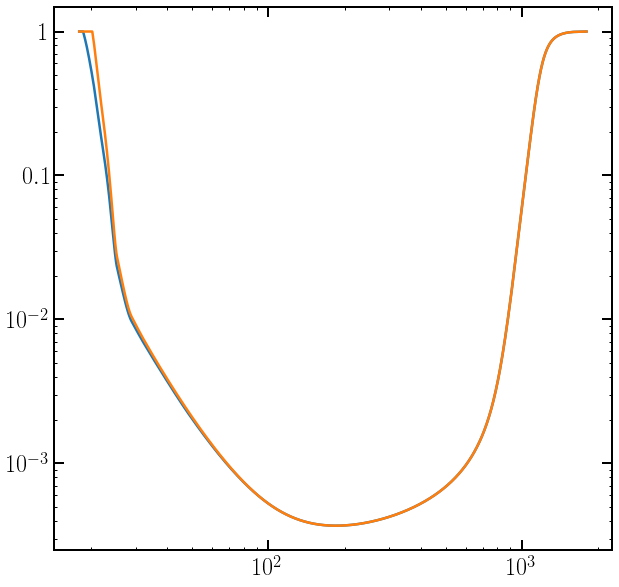

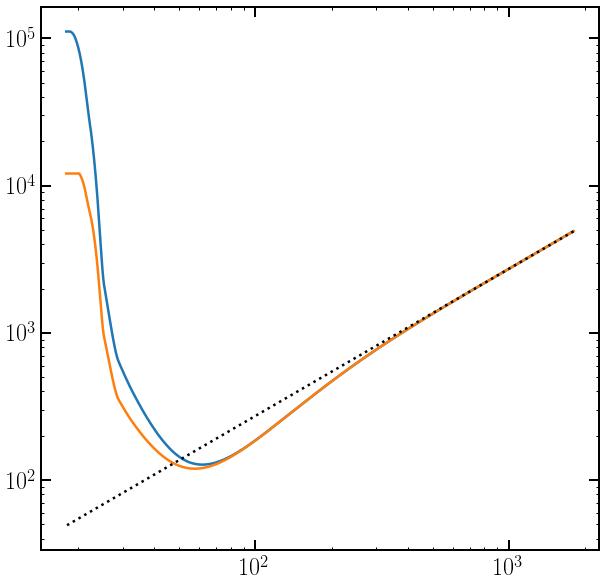

In [89]:
plt.figure()
plt.plot(a[3].rs, a[0])
plt.plot(b[3].rs, b[0])
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')


plt.figure()
plt.plot(a[3].rs, a[1]/phys.kB)
plt.plot(b[3].rs, b[1]/phys.kB)
plt.plot(a[3].rs, phys.TCMB(a[3].rs)/phys.kB, 'k:')
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')


In [ ]:
a[0]
a[3].rs[1:]

In [ ]:
a = 2
str(a)